# Constant Opacity
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  12/07/2023          |
| Updated |  07/19/2024          |

## [Quantities](https://github.com/PrincetonUniversity/athena/wiki/Non-relativistic-Radiation-Transport#units)

In [1]:
# BEGIN /athinput.[pgen]
# <radiation>
T_unit           = 6.14e3              # T_0 [K]
density_unit     = 4.28e-14            # \rho_0 [g/cm^3]
molecular_weight = 0.6                 # \mu
# END /athinput.[pgen]

# BEGIN athena/src/nr_radiation/radiation.cpp
# NRRadiation::NRRadiation(...) {
#   // universal constants we need
#   // https://physics.info/constants/
#   // arad = 4 * sigma/c
arad = 7.565733250033928e-15
c_speed = 2.99792458e10 # // speed of light

tunit = T_unit                # pin->GetOrAddReal("radiation","T_unit",1.e7);
rhounit = density_unit        # pin->GetOrAddReal("radiation","density_unit",1.0);
mol_weight = molecular_weight # pin->GetOrAddReal("radiation","molecular_weight",0.6);

# ...
#   }  else if (user_unit_ == 1) {
#      // calculate prat and crat based on user provided unit
r_ideal = 8.314462618e7/mol_weight
prat = arad * tunit * tunit * tunit/(rhounit * r_ideal)
cs_iso = (r_ideal * tunit)**(1/2)
crat = c_speed/cs_iso
# END athena/src/nr_radiation/radiation.cpp

# Extra conversions
m_u              = 1.66e-24            # atomic mass constant [g]
k_B              = 1.38e-16            # Boltzmann constant [erg/K]
P_0 = density_unit*r_ideal*T_unit
P_0alt = k_B*density_unit*T_unit/molecular_weight/m_u
prat_check = arad*T_unit**4/P_0

print(f'prat = {prat:.2e}')
print(f'crat = {crat:.2e}')
print(rf' P_0 = \rho_0*R_ideal*T_0       = {P_0:.2e} g/cm/s^2')
print(rf' P_0 = k_B*\rho_0*T_0/(\mu*m_u) = {P_0alt:.2e} g/cm/s^2')
print(f'(prat_check = a_r*T_0^4/P_0 = {prat_check:.2e})')


prat = 2.95e+02
crat = 3.25e+04
 P_0 = \rho_0*R_ideal*T_0       = 3.64e-02 g/cm/s^2
 P_0 = k_B*\rho_0*T_0/(\mu*m_u) = 3.64e-02 g/cm/s^2
(prat_check = a_r*T_0^4/P_0 = 2.95e+02)


From Jiang ([2021](https://ui.adsabs.harvard.edu/abs/2021ApJS..253...49J/abstract), under eq. 10),
$$
  T = \frac{P}{R_\mathrm{ideal}\rho},
$$
where $R_\mathrm{ideal} = R/\mu$.
$R$ is the gas constant, and the [mean molecular weight](http://astronomy.nmsu.edu/jasonj/565/docs/09_03.pdf) $\mu = \overline{m}/m_\mathrm{u}$, where $\overline{m}$ is the mean mass per particle and the [atomic mass constant](https://en.wikipedia.org/wiki/Dalton_(unit)) $m_\mathrm{u} \approx m_\mathrm{p}$, the proton mass.

## Stellar Properties

The luminosity $L = FA$, where $F$ is the flux and $A$ is the emission surface area.
For an emitting sphere with radius $R$, and $F = ca_\mathrm{r}T^4/4$ (Rybicki & Lightman 1979, eq. 1.43), where $ca_\mathrm{r}/4 = \sigma$ the Stefan–Boltzmann constant $\left[\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{K}^{-4}\right]$

\begin{align}
  L &= \frac{ca_\mathrm{r}}{4} T^4(4\pi R^2) \\
    &= \pi ca_\mathrm{r} T^4R^2
\end{align}

## Theoretical Model

See [Desmos](https://www.desmos.com/) for interactive plots of 
- [$T = P/\rho$](https://www.desmos.com/calculator/ptyevuziu7)
- [$\rho_\mathrm{mid}$](https://www.desmos.com/calculator/ubtsqj1ltb)
- [$\rho(\theta)$](https://www.desmos.com/calculator/marlugmhhr)

In code units,
\begin{align*}
  T(r, \theta) &= \frac{P(r, \theta)}{\rho} = \frac{P_0}{\rho_0}\left(\frac{r\sin\theta}{r_0}\right)^{-1/2}, \\
  \rho_\mathrm{mid}(r) &= \frac{\rho_0\left(\frac{r + r_0}{r_0}\right)^{-9/4}}{1 + \exp\left[-\mathrm{e}^\mathrm{e}\left(\frac{r - r_0}{r_0}\right)\right]}, \\
  \rho(r, \theta) &= \rho_\mathrm{mid}\exp\left[\frac{GMr}{P}\left(\frac{1}{\sqrt{r^2\sin^2\theta + r^2\cos^2\theta}} - \frac{1}{r\sin\theta}\right)\right], \\
                  &= \rho_\mathrm{mid}\exp\left[\frac{GM}{P}\left(1 - \frac{1}{\sin\theta}\right)\right]. \\
\end{align*}

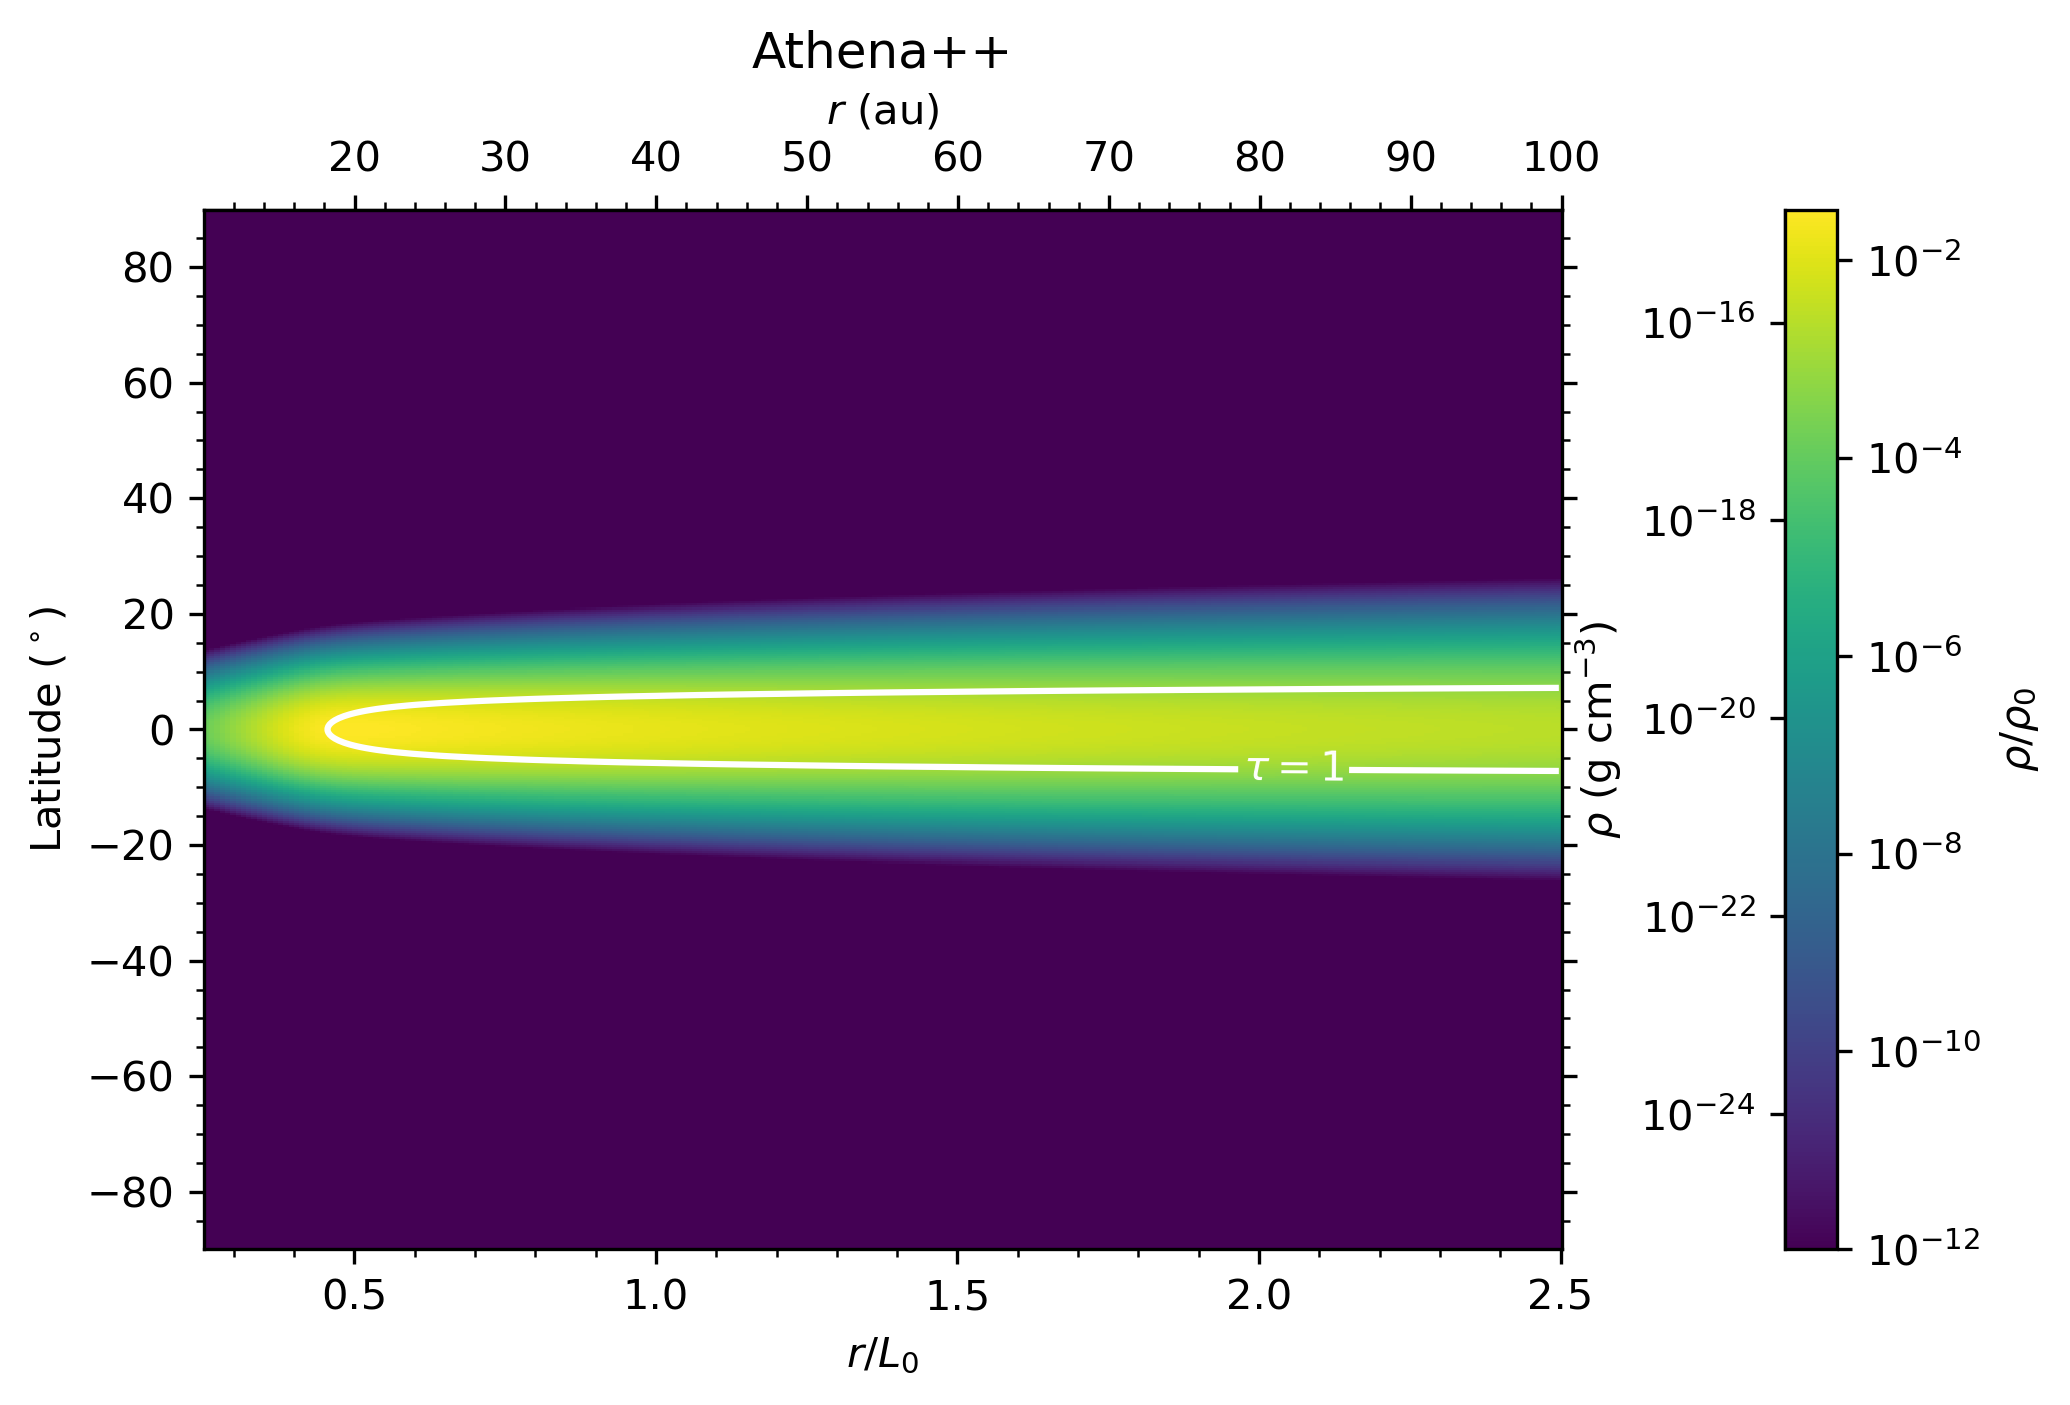

In [2]:
#===============================================================================
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# conversions
rad2deg = 180/np.pi       # [deg]

# Read and plot
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'const_opac_raytrace'
run = '512nx2'
path = f'{base}/{problem_id}/implicit/heat/{run}'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
density_unit = athinput['radiation']['density_unit']
length_unit = athinput['radiation']['length_unit']
T_unit = athinput['radiation']['T_unit']
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00000.athdf')
dtau = athdf['Sigma_a_0'][0]*np.diff(athdf['x1f'])
tau_field = np.cumsum(dtau, axis=1)
im = ax.pcolormesh(athdf['x1v'], 90-athdf['x2v']*rad2deg, athdf['rho'][0],
                   norm=colors.LogNorm())

# Constants
au      = 1.495978707e13  # astronomical unit [cm]
L_au    = length_unit/au  # [au]

# Format (sub)plots
def fmt(x):
  return rf'$\tau={x:.0f}$'
def r2au(r):
  return r*L_au
def rho2cgs(rho):
  return rho*density_unit

ax_r = ax.secondary_xaxis('top', functions=(r2au, r2au))
cbar_rho = plt.colorbar(im, label=r'$\rho/\rho_0$', pad=0.12)
cbar_rho_cgs = cbar_rho.ax.secondary_yaxis('left', functions=(rho2cgs, rho2cgs))
ax_r.minorticks_on()
ax_r.set(xlabel=r'$r$ (au)')
cbar_rho_cgs.set(ylabel=r'$\rho$ (g cm$^{-3}$)')

CS = ax.contour(athdf['x1v'], 90-athdf['x2v']*rad2deg, tau_field, [1, 1e5],
                colors=['w', 'w'])
ax.clabel(CS, CS.levels, fmt=fmt)
ax.minorticks_on()
ax.set(xlabel='$r/L_0$', ylabel=r'Latitude ($^\circ$)', title='Athena++')
ax.tick_params(axis='both', which='both', right=True)

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dustkappa_constant.inp
Opacity at 0.50um :  21.839999999999996


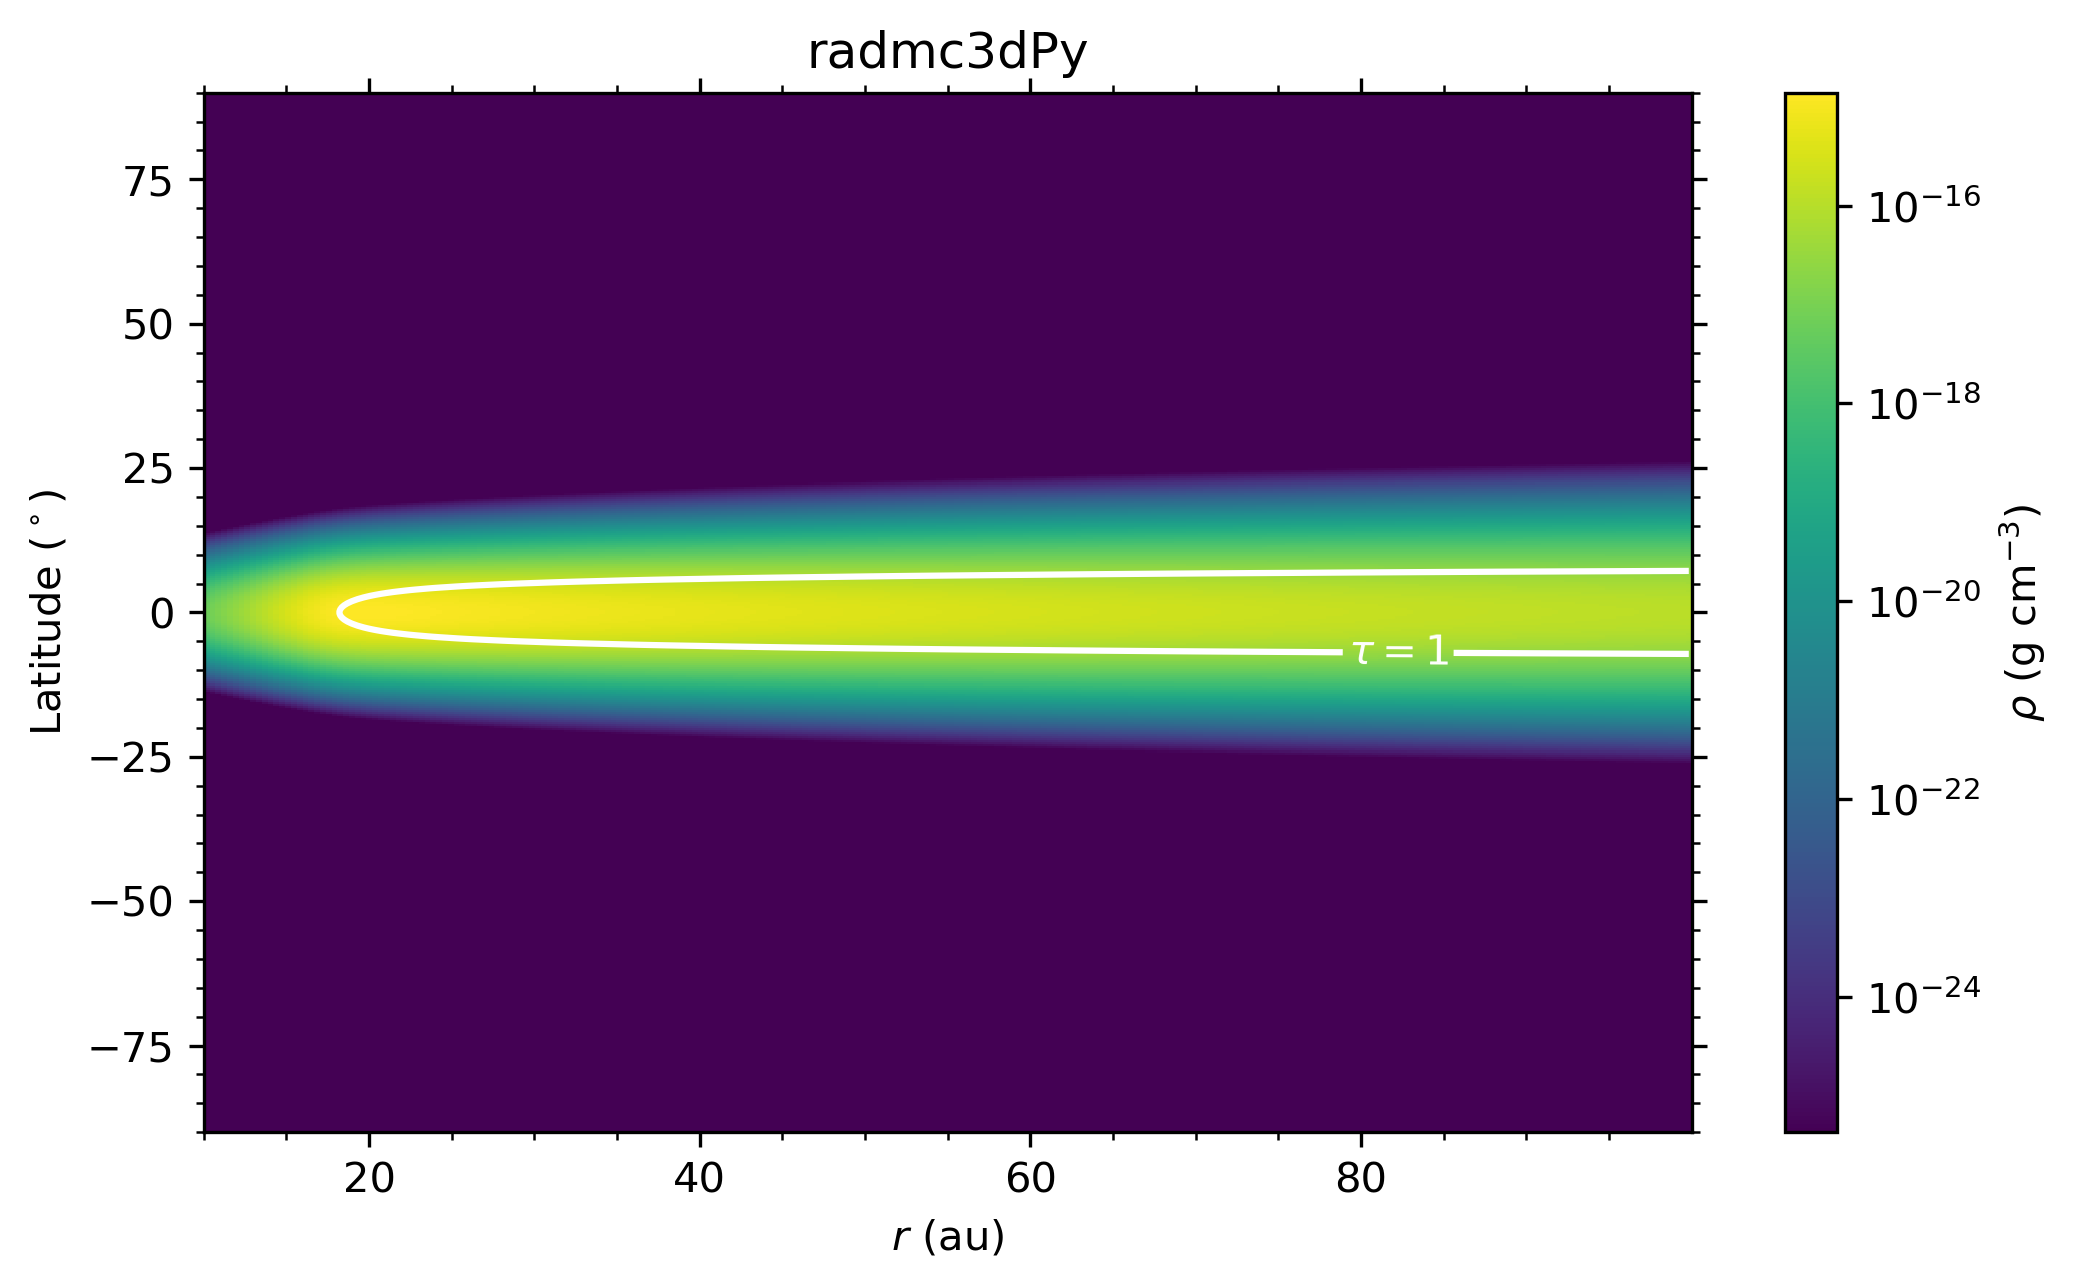

In [3]:
#===============================================================================
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *

# Conversions
rad2deg = 180/np.pi # [deg]

# Prepare plots
def fmt(x):
    return rf'$\tau={x:.0f}$'
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)

# RADMC-3D
data = analyze.readData(ddens=True)
im = ax.pcolormesh(data.grid.x/natconst.au, 90-data.grid.y*rad2deg,
                   data.rhodust[:,:,0,0].T, norm=colors.LogNorm())
data.getTau(wav=0.5)
CS = ax.contour(data.grid.x/natconst.au, 90-data.grid.y*rad2deg,
                data.taux[:,:,0].T, [1, 1e4], colors=['w', 'w'])

# Format (sub)plots
plt.colorbar(im, label=r'$\rho$ (g cm$^{-3}$)')
ax.clabel(CS, CS.levels, fmt=fmt)
ax.minorticks_on()
ax.set(xlabel='$r$ (au)', ylabel=r'Latitude ($^\circ$)',
       title='radmc3dPy')
ax.tick_params(axis='both', which='both', top=True, right=True)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp


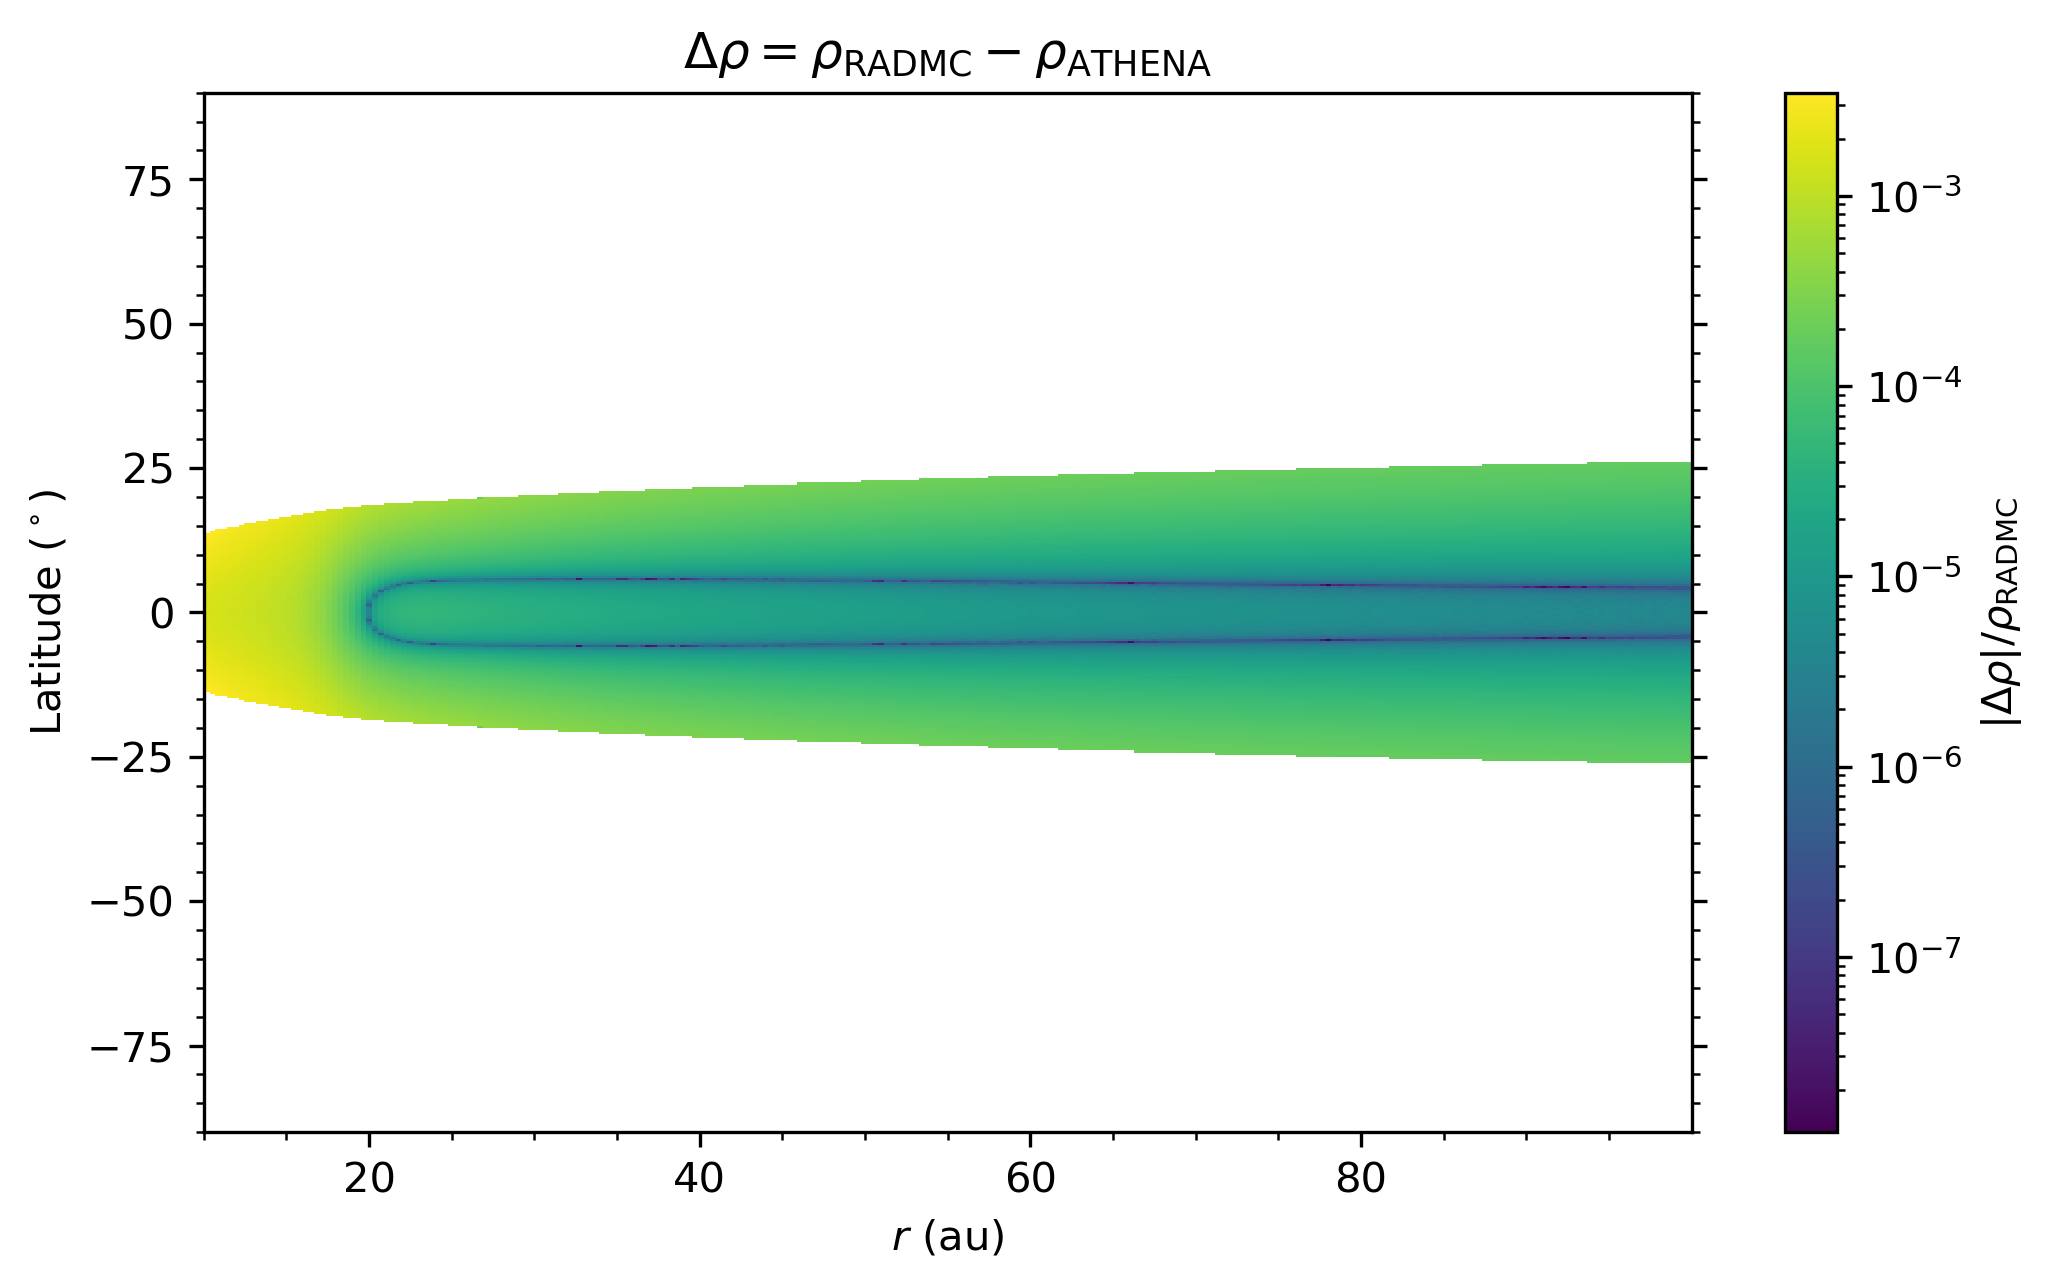

In [4]:
#===============================================================================
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *

# Conversions
rad2deg = 180/np.pi # [deg]

# Plot
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
data = analyze.readData(ddens=True)
drho = data.rhodust[:,:,0,0].T - athdf['rho'][0]*density_unit
rel_err = np.abs(drho)/data.rhodust[:,:,0,0].T
im = ax.pcolormesh(data.grid.x/natconst.au, 90-data.grid.y*rad2deg, rel_err,
                   norm=colors.LogNorm())

# Format (sub)plots
plt.colorbar(im, label=r'$|\Delta\rho|/\rho_\mathrm{RADMC}$')
ax.minorticks_on()
ax.set(xlabel='$r$ (au)', ylabel=r'Latitude ($^\circ$)',
       title=r'$\Delta\rho = \rho_\mathrm{RADMC} - \rho_\mathrm{ATHENA}$')
ax.tick_params(axis='both', which='both', right=True)

## Temperature Profiles

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


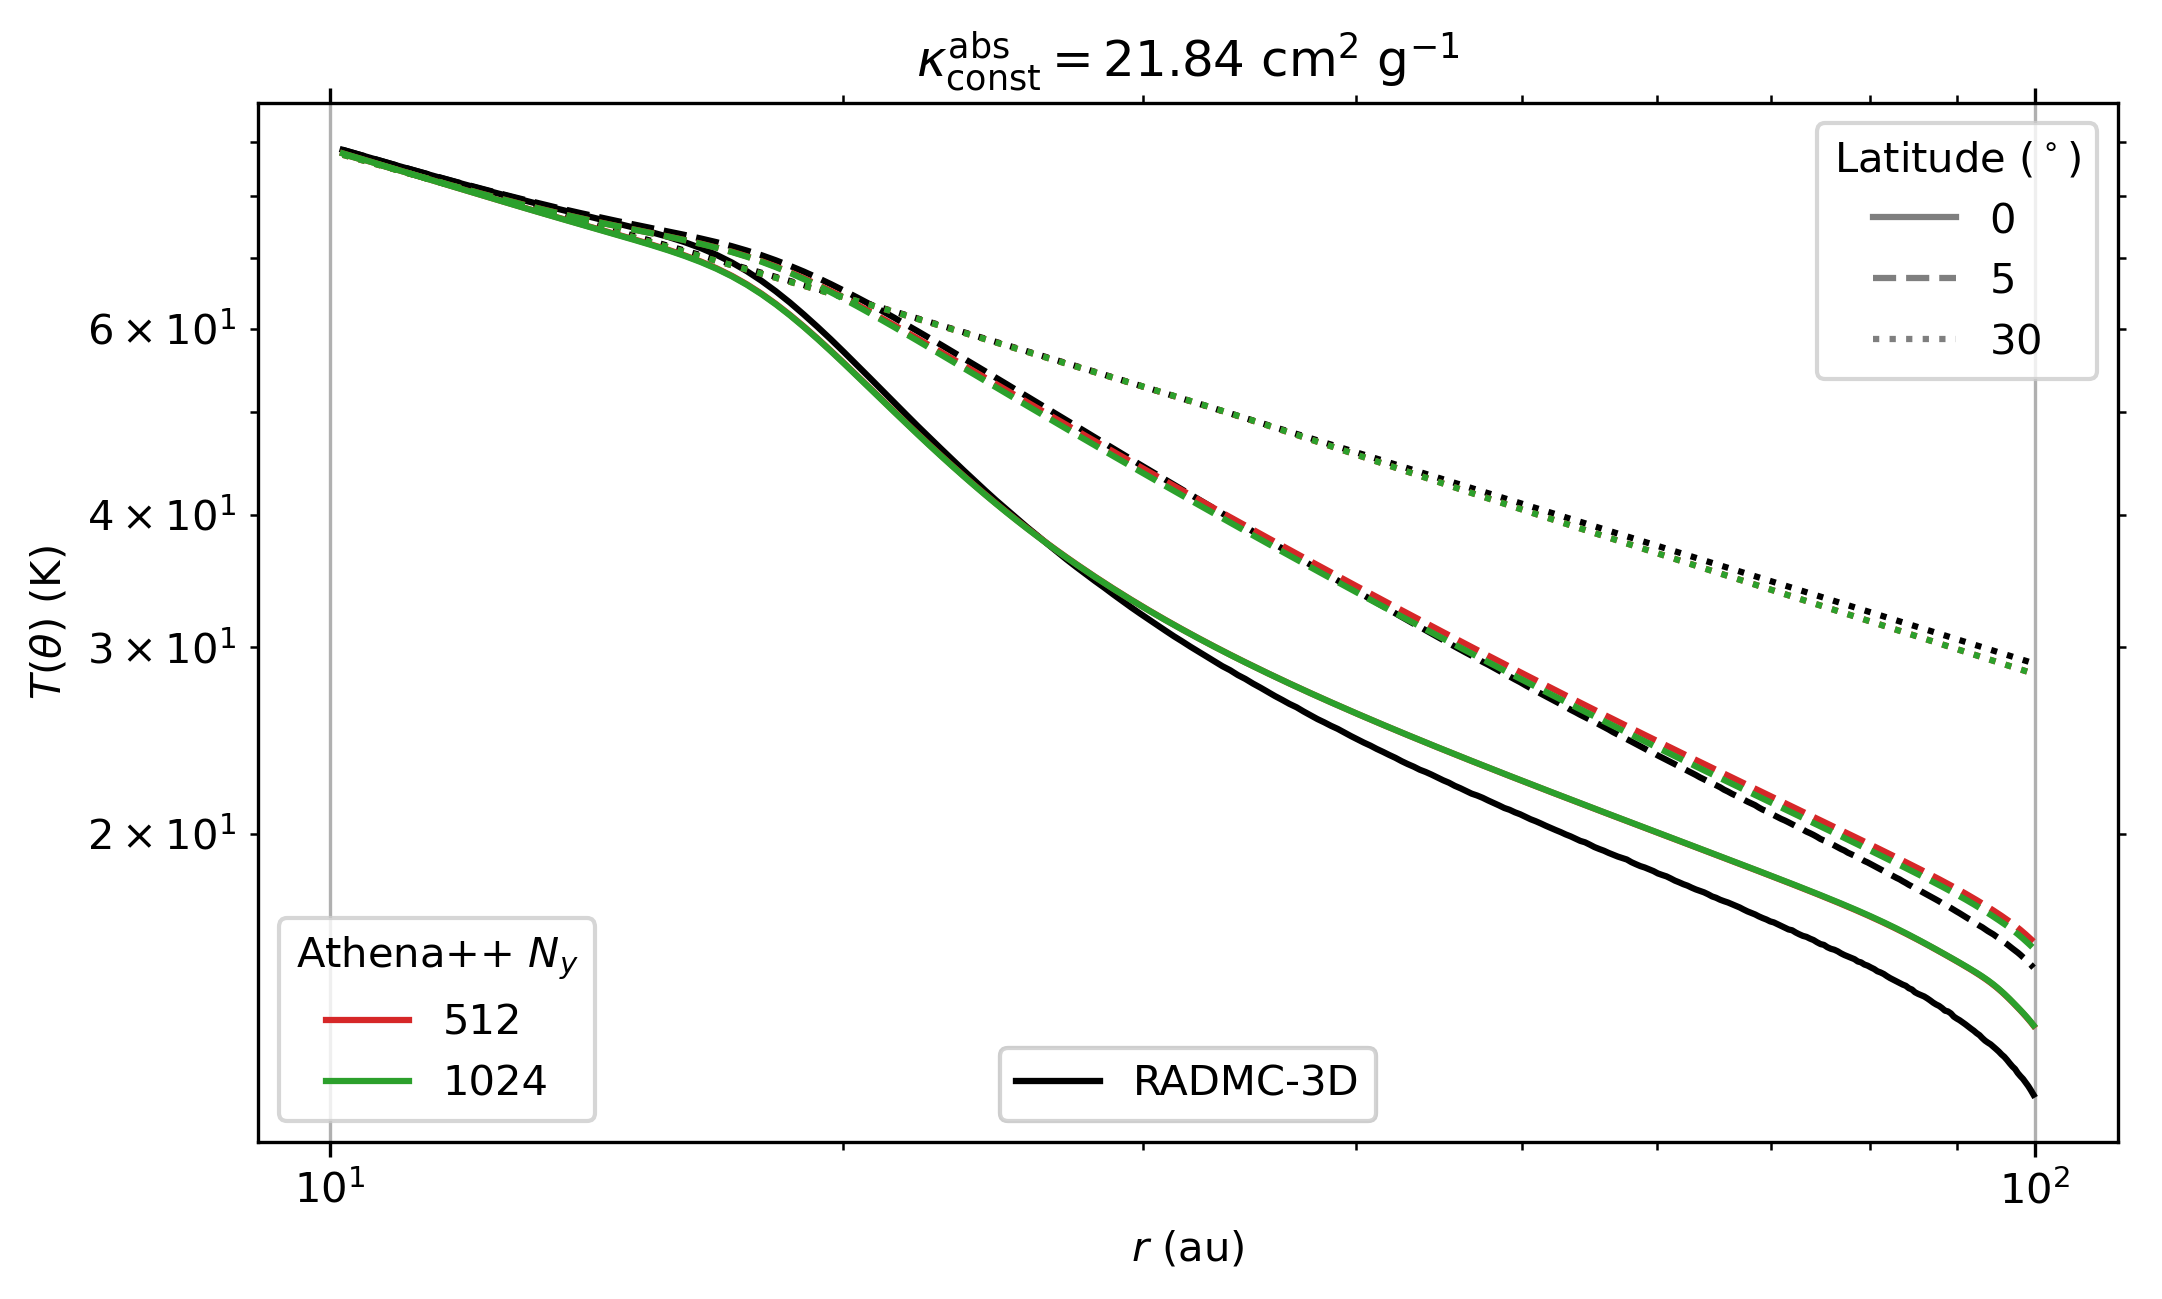

In [5]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions
rad2deg = 180/np.pi # [deg]

# Set up plots
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
tab_colors = ['tab:red', 'tab:green', 'tab:blue',
              'tab:purple', 'tab:pink','tab:cyan', 'tab:olive',
              'tab:brown', 'tab:gray']
# lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 85, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# Read and plot RADMC-3D solutions
data = analyze.readData(ddens=True, dtemp=True)
dtheta = (data.grid.yi[-1] - data.grid.yi[0])/data.grid.ny
ref_soln.append(ax.plot([], [], color='black', label='RADMC-3D')[0])

for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(data.grid.x/natconst.au, data.dusttemp[:,j,0,0], 'black',
            ls=lss[th])
    ls_thetas.append(ax.plot([], [], color='tab:gray', ls=lss[th],
                     label=rf'${90-theta_deg}$')[0])

# Read and plot Athena++ solutions
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'const_opac_raytrace'
runs = ['512nx2', '1024nx2']

for i, run in enumerate(runs):
    path = f'{base}/{problem_id}/implicit/heat/{run}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
             /athinput['mesh']['nx2']
    L_0 = athinput['radiation']['length_unit']
    T_0 = athinput['radiation']['T_unit']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
    T_field = athdf['press'][0]/athdf['rho'][0]*T_0
    c_solns.append(ax.plot([], [], tab_colors[i], label=f'{run[:-3]}')[0])

    for th, theta_deg in enumerate(theta_degs):
        j = int(theta_deg/rad2deg/dtheta)
        ax.plot(athdf['x1v']*L_0/natconst.au, T_field[j, :], tab_colors[i],
                ls=lss[th])

# Plot ghost points for colorless line style and add legends
ls_legend = plt.legend(title=r'Latitude ($^\circ)$', handles=ls_thetas,
                       loc='upper right')
color_legend = plt.legend(title=r'Athena++ $N_y$', handles=c_solns,
                          loc='lower left')
radmc_legend = plt.legend(handles=ref_soln, loc='lower center')
ax.add_artist(ls_legend)
ax.add_artist(color_legend)
ax.add_artist(radmc_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xlabel=r'$r$ (au)', ylabel=r'$T(\theta)$ (K)', xscale='log',
       yscale='log', title=r'$\kappa_\mathrm{const}^\mathrm{abs}=21.84$ cm$^2$ g$^{-1}$')
ax.tick_params(axis='both', which='both', top=True, right=True)
plt.savefig('temp_profiles.png', bbox_inches='tight', pad_inches=0.01)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


IndexError: index 0 is out of bounds for axis 0 with size 0

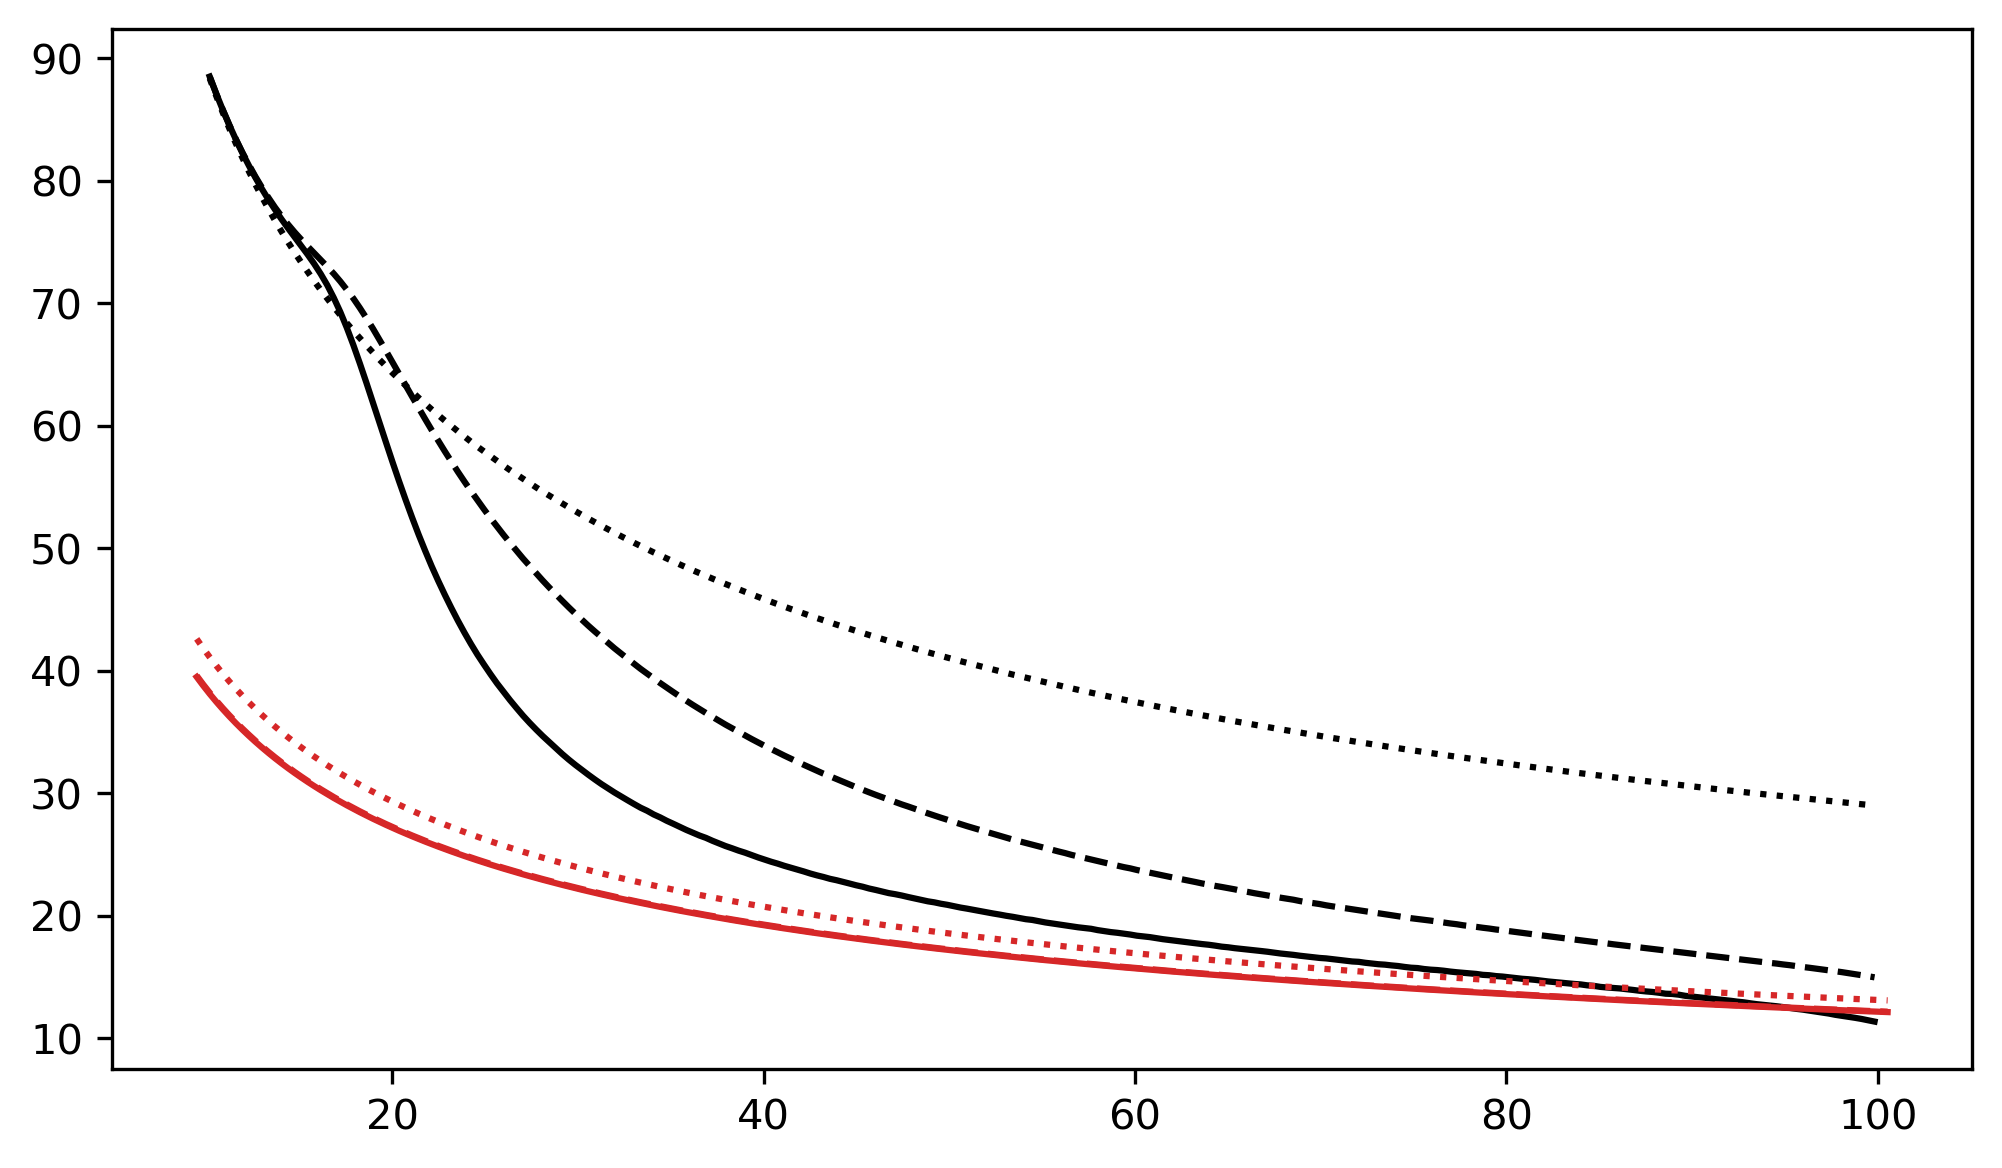

In [11]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions
rad2deg = 180/np.pi # [deg]

# Set up plots
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue',
              'tab:purple', 'tab:pink','tab:cyan', 'tab:olive',
              'tab:brown', 'tab:gray']
# lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 85, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# Read and plot RADMC-3D solutions
data = analyze.readData(ddens=True, dtemp=True)
dtheta = (data.grid.yi[-1] - data.grid.yi[0])/data.grid.ny
ref_soln.append(ax.plot([], [], color='black', label='RADMC-3D')[0])

for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(data.grid.x/natconst.au, data.dusttemp[:,j,0,0], 'black',
            ls=lss[th])
    ls_thetas.append(ax.plot([], [], color='tab:gray', ls=lss[th],
                     label=rf'${90-theta_deg}$')[0])

# Read and plot Athena++ solutions
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'const_opac_raytrace'
runs = ['nfreq1', 'nfreq2', 'nfreq4', 'nfreq8']

for i, run in enumerate(runs):
    path = f'{base}/const_opac_raytrace/implicit/mf_flux/{run}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
             /athinput['mesh']['nx2']
    L_0 = athinput['radiation']['length_unit']
    T_0 = athinput['radiation']['T_unit']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf',
                              num_ghost=2)
    T_field = athdf['press'][0]/athdf['rho'][0]*T_0
    c_solns.append(ax.plot([], [], tab_colors[i], label=run[5:])[0])

    for th, theta_deg in enumerate(theta_degs):
        j = int(theta_deg/rad2deg/dtheta)
        ax.plot(athdf['x1v']*L_0/natconst.au, T_field[j, :], tab_colors[i],
                ls=lss[th])

# Plot ghost points for colorless line style and add legends
ls_legend = plt.legend(title=r'Latitude ($^\circ)$', handles=ls_thetas,
                       loc='upper right')
color_legend = plt.legend(title=r'Athena++ $N_y$', handles=c_solns,
                          loc='lower left')
radmc_legend = plt.legend(handles=ref_soln, loc='lower center')
ax.add_artist(ls_legend)
ax.add_artist(color_legend)
ax.add_artist(radmc_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xlabel=r'$r$ (au)', ylabel=r'$T(\theta)$ (K)', xscale='log',
       yscale='log', title=r'$\kappa_\mathrm{const}^\mathrm{abs}=21.84$ cm$^2$ g$^{-1}$')
ax.tick_params(axis='both', which='both', top=True, right=True)
plt.savefig('temp_profiles.png', bbox_inches='tight', pad_inches=0.01)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat
Reading mean_intensity.out


AthenaError: Ghost zones detected but "num_ghost" keyword set to zero.

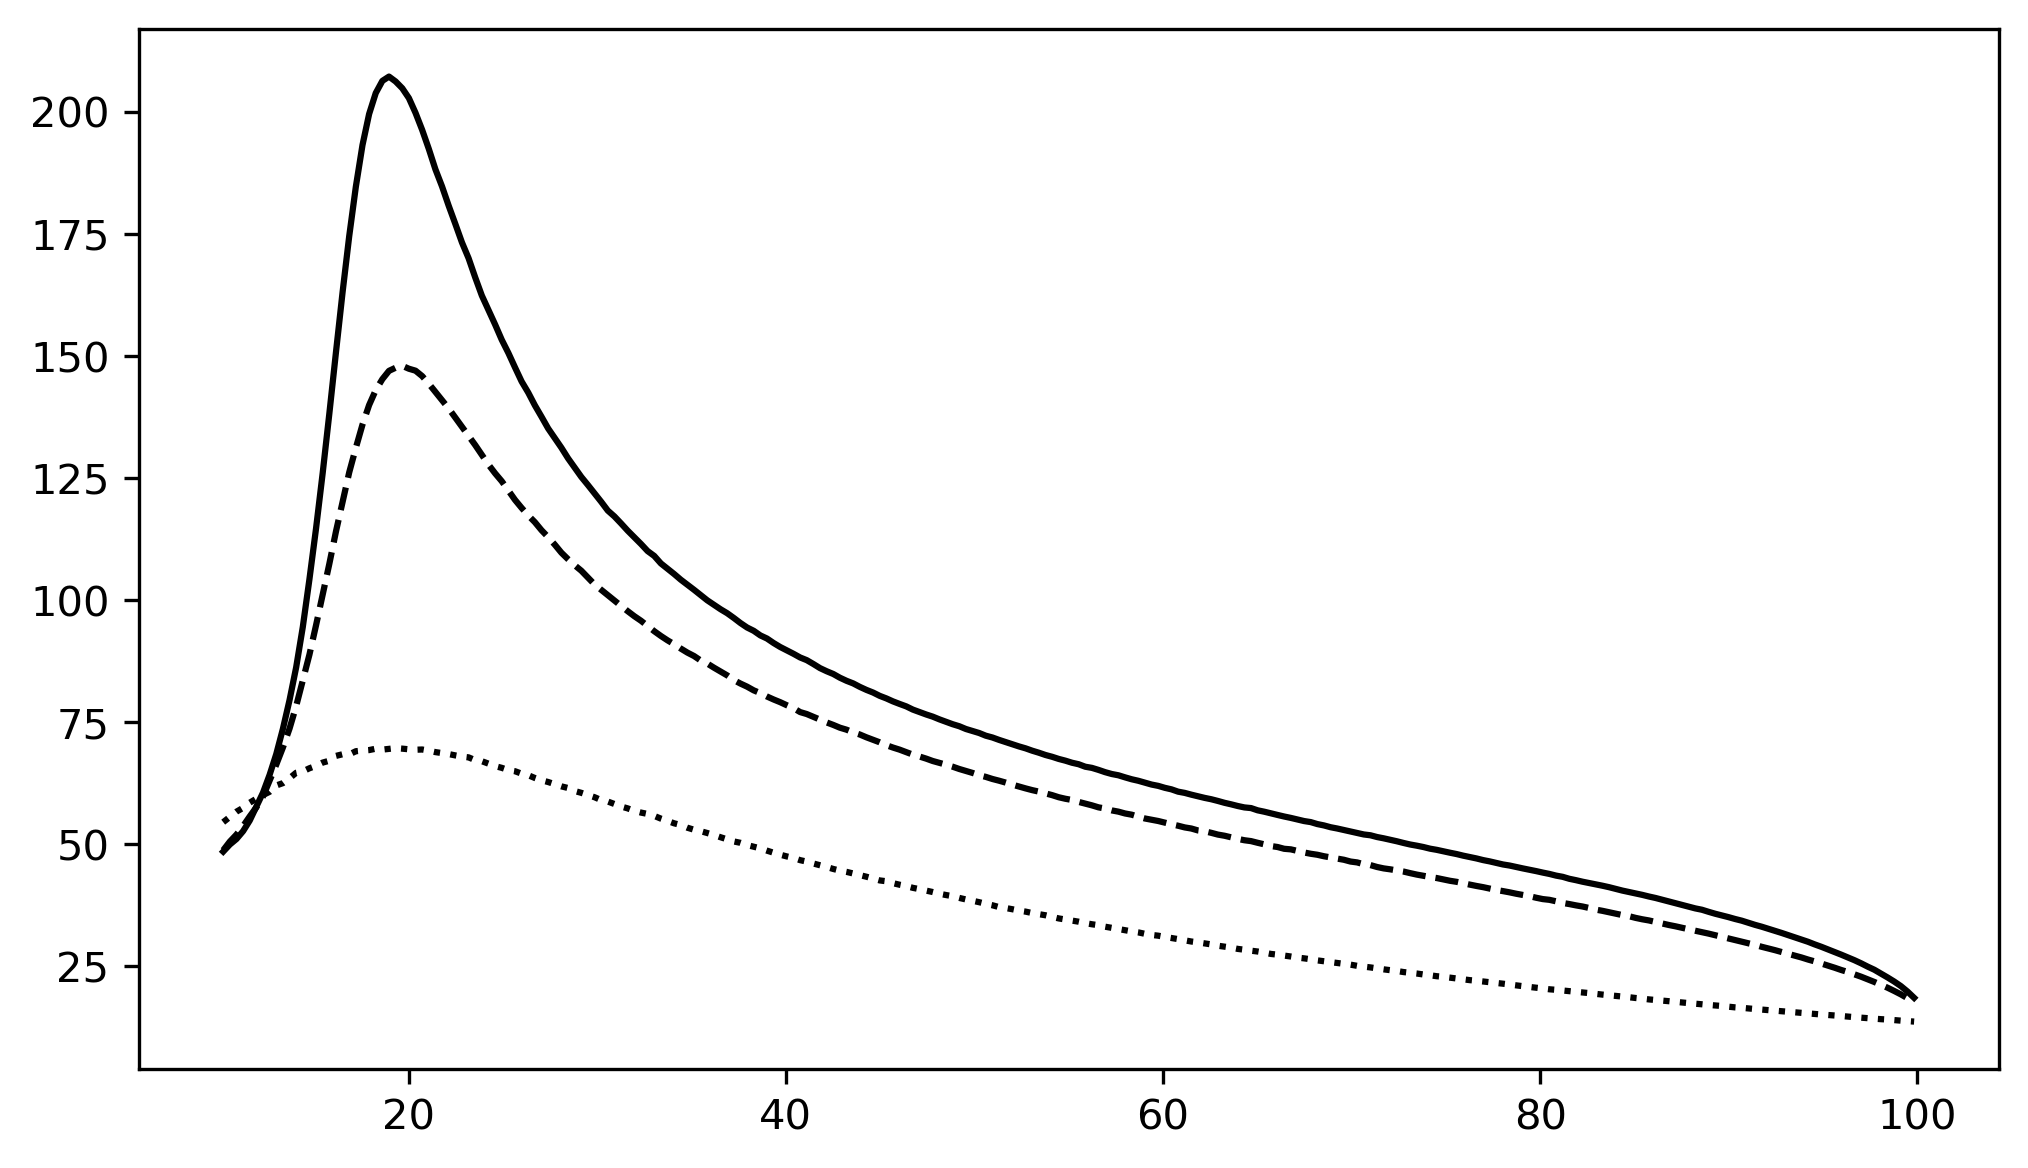

In [ ]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions, constants and units
rad2deg          = 180/np.pi           # [deg]
arad = 7.565733250033928e-15
c_speed = 2.99792458e10 # // speed of light
length_unit      = 5.98e14             # L_0 [cm]
T_unit           = 6.14e3              # T_0 [K]
au               = 1.495978707e13      # astronomical unit [cm]
L_au             = length_unit/au      # [au]
R                = 1.16e-4             # solar radius [L_0]
T                = 9.42e-1             # solar temperature [T_0]

# Prepare plots
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue',
              'tab:purple', 'tab:pink','tab:cyan', 'tab:olive',
              'tab:brown', 'tab:gray']
theta_degs = [90, 85, 60]
lss = ['solid', 'dashed', 'dotted']
c_solns, ls_thetas, ref_soln = [], [], []

# ADMC-3D
data = analyze.readData(ddens=True, dtemp=True, mint=True)
dtheta = (data.grid.yi[-1] - data.grid.yi[0])/data.grid.ny
ref_soln.append(ax.plot([], [], color='black', label='RADMC-3D')[0])
F = 4*np.pi*np.abs(np.trapz(data.meanint, data.freq, axis=-1))
for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(data.grid.x/natconst.au, F[:,j,0], color='black', ls=lss[th])
    ls_thetas.append(ax.plot([], [], color='tab:gray', ls=lss[th],
                     label=rf'${90-theta_deg}$')[0])

# Athena++
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'const_opac_raytrace'
runs = ['nfreq1', 'nfreq2', 'nfreq4', 'nfreq8']
for i, run in enumerate(runs):
  path = f'{base}/const_opac_raytrace/implicit/mf_flux/{run}'
  athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
  dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
           /athinput['mesh']['nx2']
  L_0 = athinput['radiation']['length_unit']
  T_0 = athinput['radiation']['T_unit']
  athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
  Fx_field = np.zeros_like(athdf['rho'][0])
  try:
    N_f = athinput['radiation']['n_frequency']
    for f in range(N_f):
      Fx_field += athdf[f'Fr_{f}_1'][0]
    Fx_field *= c_speed*arad*T_0**4
  except KeyError:
    Fx_field = athdf['Fr1'][0]*c_speed*arad*T_0**4
  for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(athdf['x1v']*L_0/natconst.au, Fx_field[j, :], color=tab_colors[i],
            ls=lss[th])
  c_solns.append(ax.plot([], [], color=tab_colors[i], label=run[5:])[0])

# Plot ghost points for colorless line style and add legends
ls_legend = plt.legend(title=r'Latitude ($^\circ)$', handles=ls_thetas,
                       loc='upper right')
color_legend = plt.legend(title=r'$N_f$ (Athena++)', handles=c_solns,
                          loc='lower left')
radmc_legend = plt.legend(handles=ref_soln, loc='lower center')
ax.add_artist(ls_legend)
ax.add_artist(color_legend)
ax.add_artist(radmc_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xscale='log', yscale='log', xlabel=r'$r$ (au)',
       ylabel=r'$\sum_{f=0}^{N_f-1}F_{x,f}(\theta)$ (erg s$^{-1}$ cm$^{-2}$)',
       title=r'$\kappa_\mathrm{const}^\mathrm{abs}=21.84$ cm$^2$ g$^{-1}$')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('filename.pdf', bbox_inches='tight', pad_inches=0.01)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat
Reading mean_intensity.out


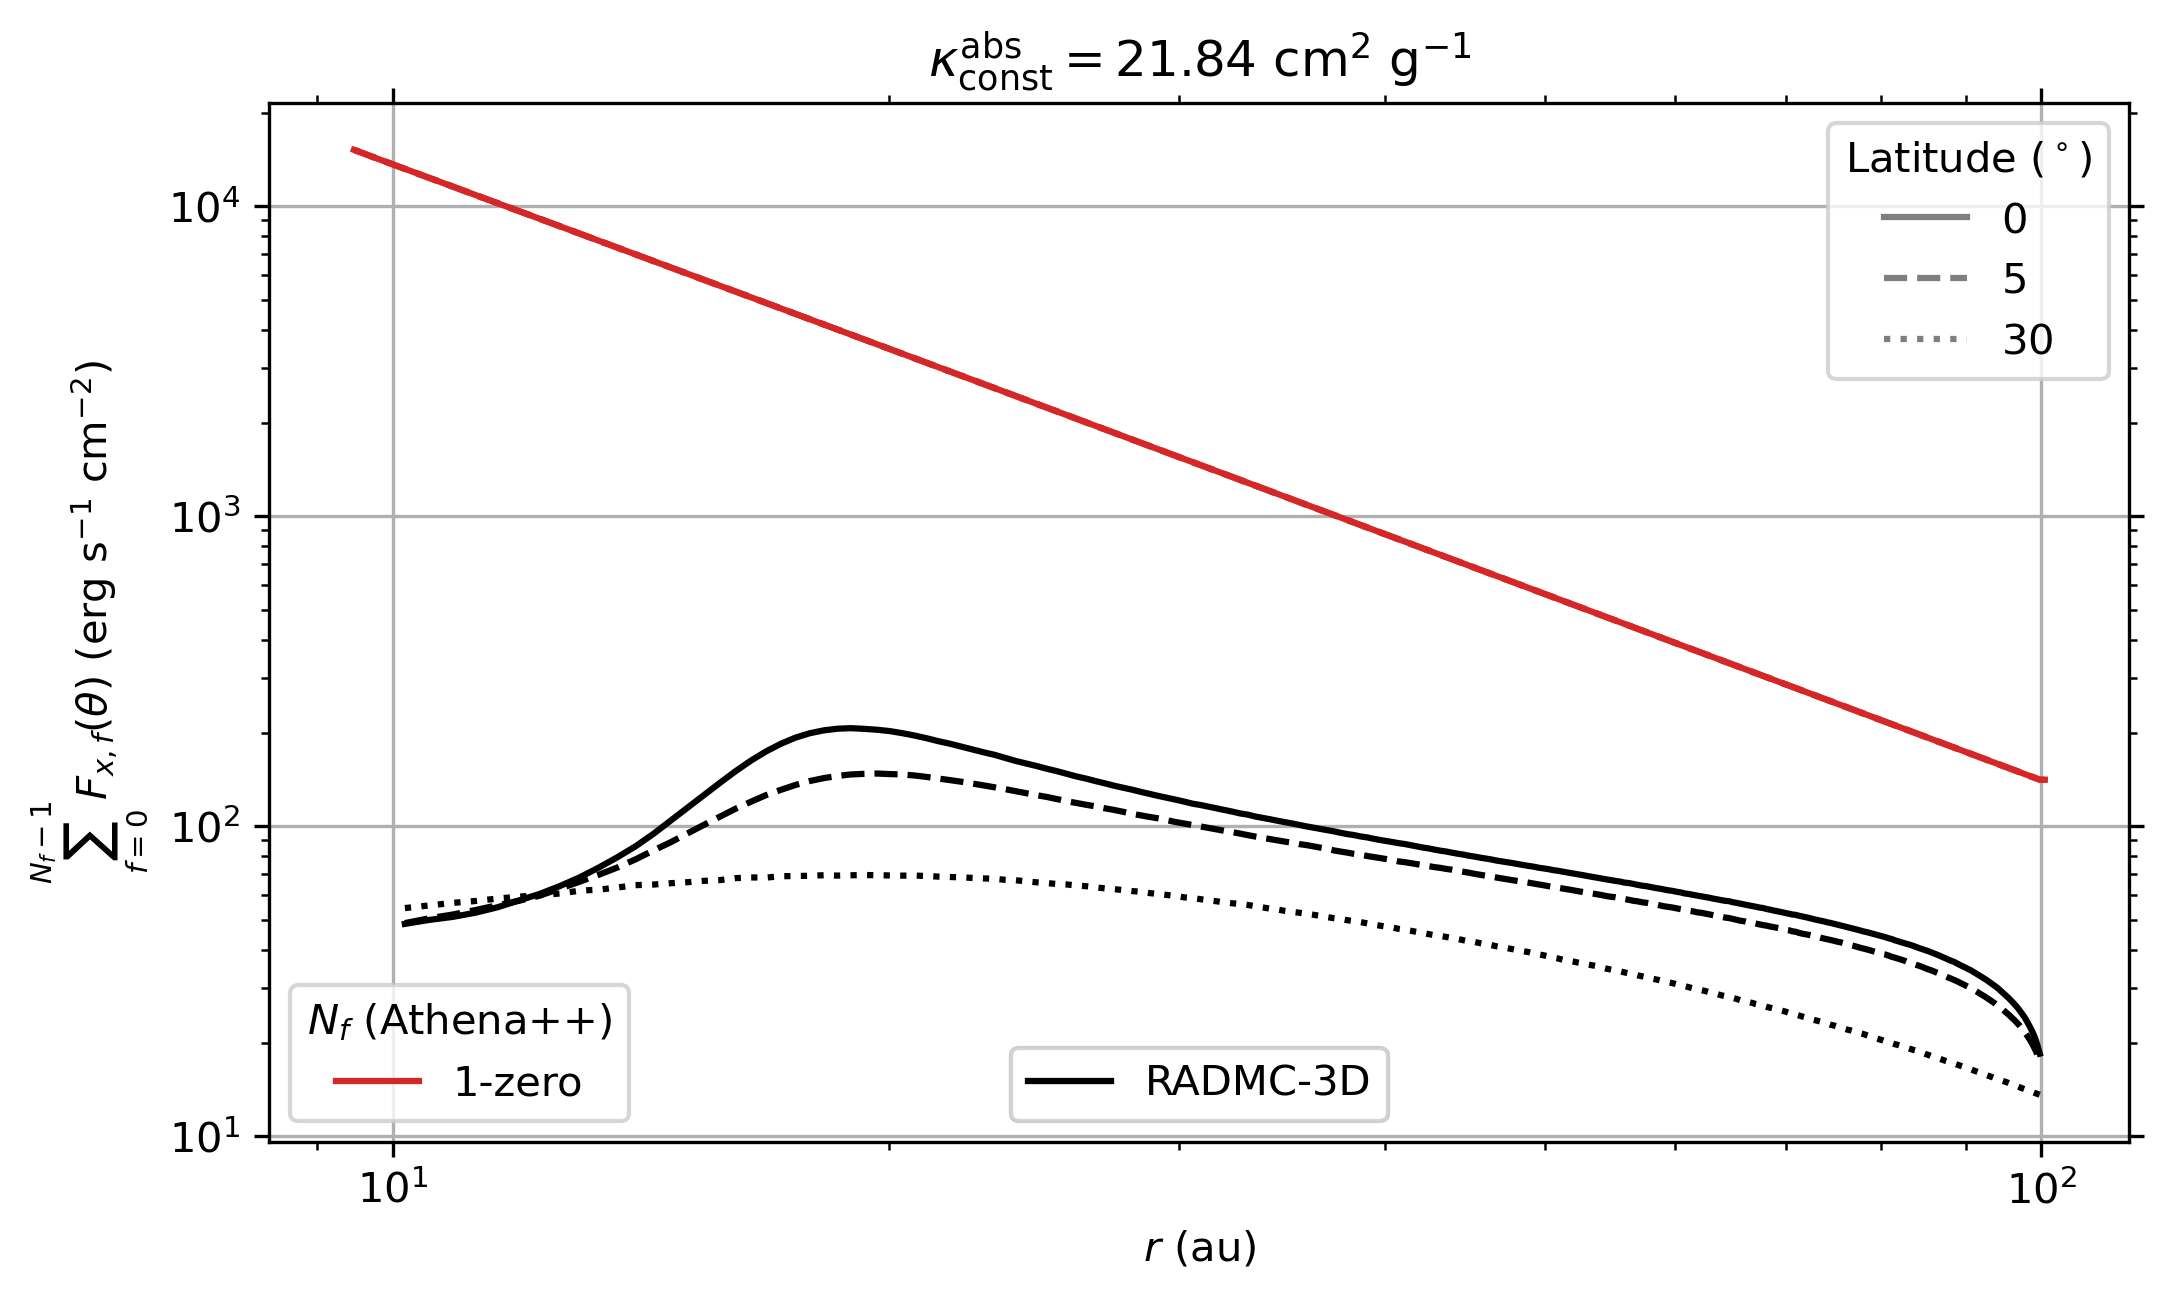

In [ ]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions, constants and units
rad2deg          = 180/np.pi           # [deg]
arad = 7.565733250033928e-15
c_speed = 2.99792458e10 # // speed of light
length_unit      = 5.98e14             # L_0 [cm]
T_unit           = 6.14e3              # T_0 [K]
au               = 1.495978707e13      # astronomical unit [cm]
L_au             = length_unit/au      # [au]
R                = 1.16e-4             # solar radius [L_0]
T                = 9.42e-1             # solar temperature [T_0]

# Prepare plots
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue',
              'tab:purple', 'tab:pink','tab:cyan', 'tab:olive',
              'tab:brown', 'tab:gray']
theta_degs = [90, 85, 60]
lss = ['solid', 'dashed', 'dotted']
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
data = analyze.readData(ddens=True, dtemp=True, mint=True)
dtheta = (data.grid.yi[-1] - data.grid.yi[0])/data.grid.ny
ref_soln.append(ax.plot([], [], color='black', label='RADMC-3D')[0])
F = 4*np.pi*np.abs(np.trapz(data.meanint, data.freq, axis=-1))
for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(data.grid.x/natconst.au, F[:,j,0], color='black', ls=lss[th])
    ls_thetas.append(ax.plot([], [], color='tab:gray', ls=lss[th],
                     label=rf'${90-theta_deg}$')[0])

# Athena++
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'const_opac_raytrace'
runs = ['nfreq1-zero']
for i, run in enumerate(runs):
  path = f'{base}/const_opac_raytrace/implicit/mf_flux/{run}'
  athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
  dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
           /athinput['mesh']['nx2']
  L_0 = athinput['radiation']['length_unit']
  T_0 = athinput['radiation']['T_unit']
  athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf',
                            num_ghost=2)
  Fx_field = np.zeros_like(athdf['rho'][0])
  try:
    N_f = athinput['radiation']['n_frequency']
    for f in range(N_f):
      Fx_field += athdf[f'Fr_{f}_1'][0]
    Fx_field *= c_speed*arad*T_0**4
  except KeyError:
    Fx_field = athdf['Fr1'][0]*c_speed*arad*T_0**4
  for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(athdf['x1v']*L_0/natconst.au, Fx_field[j, :], color=tab_colors[i],
            ls=lss[th])
  c_solns.append(ax.plot([], [], color=tab_colors[i], label=run[5:])[0])

# Plot ghost points for colorless line style and add legends
ls_legend = plt.legend(title=r'Latitude ($^\circ)$', handles=ls_thetas,
                       loc='upper right')
color_legend = plt.legend(title=r'$N_f$ (Athena++)', handles=c_solns,
                          loc='lower left')
radmc_legend = plt.legend(handles=ref_soln, loc='lower center')
ax.add_artist(ls_legend)
ax.add_artist(color_legend)
ax.add_artist(radmc_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xscale='log', yscale='log', xlabel=r'$r$ (au)',
       ylabel=r'$\sum_{f=0}^{N_f-1}F_{x,f}(\theta)$ (erg s$^{-1}$ cm$^{-2}$)',
       title=r'$\kappa_\mathrm{const}^\mathrm{abs}=21.84$ cm$^2$ g$^{-1}$')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('filename.pdf', bbox_inches='tight', pad_inches=0.01)

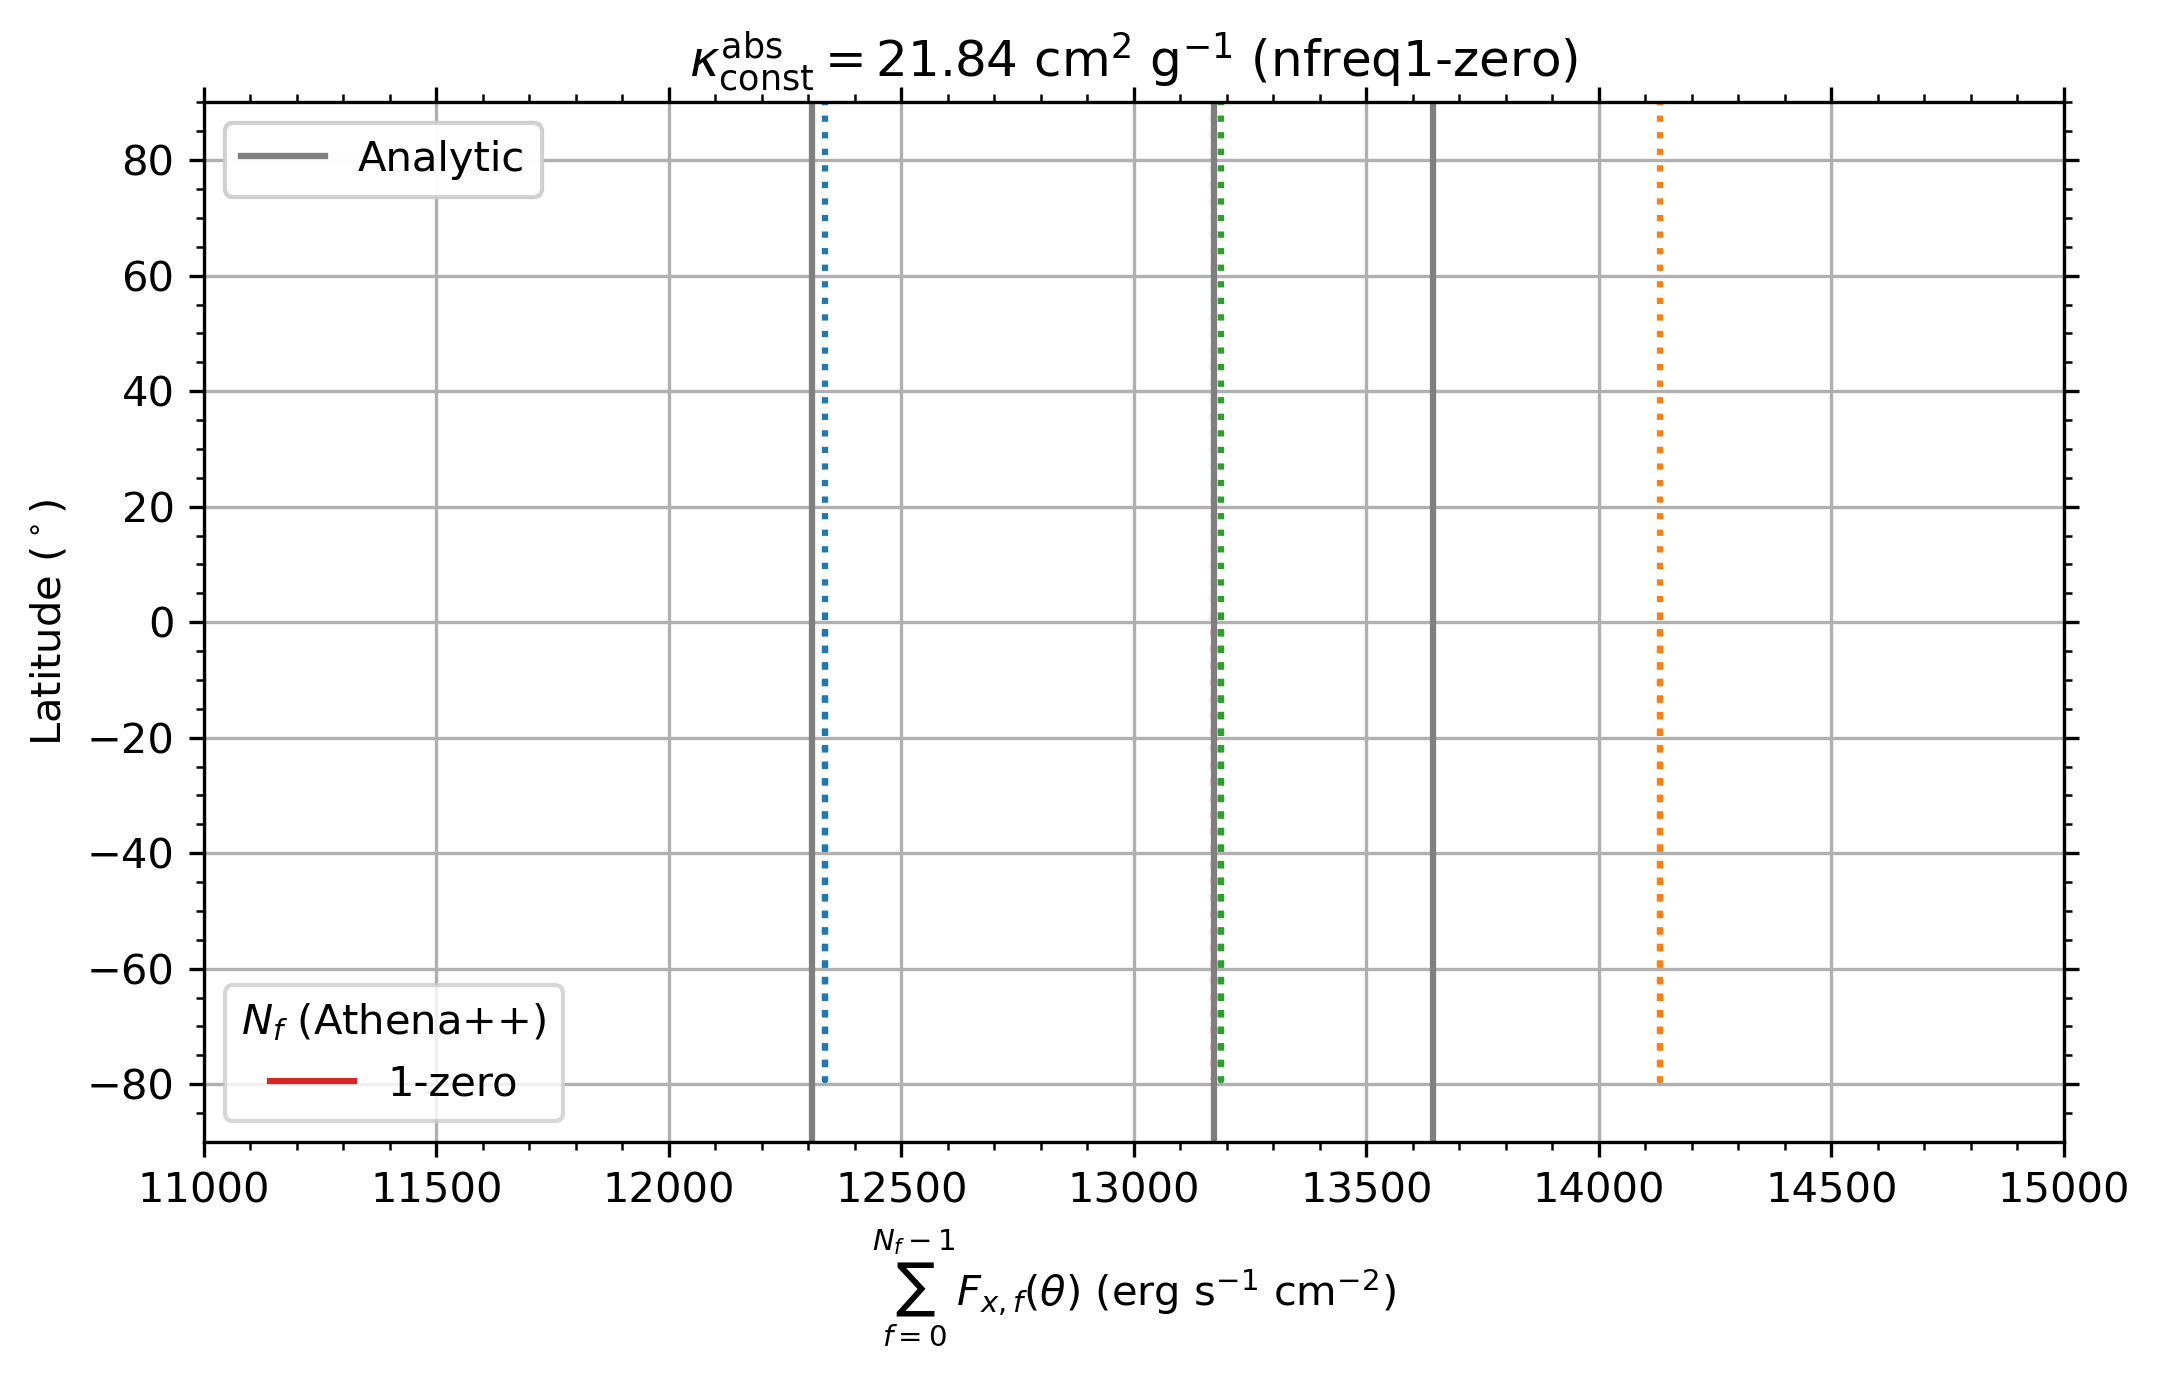

In [ ]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions, constants and units
rad2deg          = 180/np.pi           # [deg]
arad             = 7.565733250033928e-15
c_speed          = 2.99792458e10       # // speed of light
x1min            = 0.250163663377926   # minimum value of X1 [L_0]
x1max            = 2.501636633779264   # maximum value of X1
T_unit           = 6.14e3              # T_0 [K]
R                = 1.16e-4             # solar radius [L_0]
T                = 9.42e-1             # solar temperature [T_0]

# Prepare plots
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue',
              'tab:purple', 'tab:pink','tab:cyan', 'tab:olive',
              'tab:brown', 'tab:gray']
lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
c_solns, ref_soln = [], []

# Analytic
F = np.power(T, 4)*np.power(R/x1min, 2)/4

F2 = np.power(T, 4)*np.power(R/(x1min), 2)/4
ax.axvline(F*c_speed*arad*T_unit**4, c='tab:gray')
ref_soln.append(ax.plot([], [], c='tab:gray', label='Analytic')[0])

# RADMC-3D
# data = analyze.readData(mint=True)
# F = 4*np.pi*np.abs(np.trapz(data.meanint, data.freq, axis=-1))
# ax.plot(F[0,:,0], 90-data.grid.y*rad2deg, c='tab:gray', ls='dotted')
# ref_soln.append(ax.plot([], [], c='tab:gray', ls='dotted',
#                 label='RADMC-3D')[0])

# Athena++
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'const_opac_raytrace'
runs = ['nfreq1-zero']#, 'nfreq1-zero', 'nfreq1-jump', 'nfreq1-ramp']
for i, run in enumerate(runs):
  path = f'{base}/const_opac_raytrace/implicit/mf_flux/{run}'
  athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
  T_0 = athinput['radiation']['T_unit']
  athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf',
                            num_ghost=1)
  # Radial flux field
  Fx_field = np.zeros_like(athdf['rho'][0])
  try:
    N_f = athinput['radiation']['n_frequency']
    for f in range(N_f):
      Fx_field += athdf[f'Fr_{f}_1'][0]
    Fx_field *= c_speed*arad*T_0**4
  except KeyError:
    Fx_field = athdf['Fr1'][0]*c_speed*arad*T_0**4
  ax.plot(Fx_field[:, 0], 90-athdf['x2v']*rad2deg, color=tab_colors[i],
          ls='dotted')
  ax.plot(Fx_field[:, 1], 90-athdf['x2v']*rad2deg, color=tab_colors[i+1],
          ls='dotted')
  F1 = np.power(T, 4)*np.power(R/athdf['x1v'][2], 2)/4
  ax.axvline(F1*c_speed*arad*T_unit**4, c='tab:gray')
  ax.plot(Fx_field[:, 2], 90-athdf['x2v']*rad2deg, color=tab_colors[i+2],
          ls='dotted')
  F2 = np.power(T, 4)*np.power(R/athdf['x1v'][3], 2)/4
  ax.axvline(F2*c_speed*arad*T_unit**4, c='tab:gray')
  ax.plot(Fx_field[:, 3], 90-athdf['x2v']*rad2deg, color=tab_colors[i+3],
          ls='dotted')
  c_solns.append(ax.plot([], [], c=tab_colors[i], ls=lss[i],
                 label=run[5:])[0])

# Plot ghost points for colorless line style and add legends
color_legend = plt.legend(title='i+ngh', handles=c_solns, loc='lower left')
ref_legend = plt.legend(handles=ref_soln, loc='upper left')
ax.add_artist(color_legend)
ax.add_artist(ref_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(title=r'$\kappa_\mathrm{const}^\mathrm{abs}=21.84$ cm$^2$ g$^{-1}$'\
       +f' ({run})',
       xlabel=r'$\sum_{f=0}^{N_f-1}F_{x,f}(\theta)$ (erg s$^{-1}$ cm$^{-2}$)',
       ylabel=r'Latitude ($^\circ$)', xlim=(11000, 15000), ylim=(-90, 90))
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('filename.pdf', bbox_inches='tight', pad_inches=0.01)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading mean_intensity.out


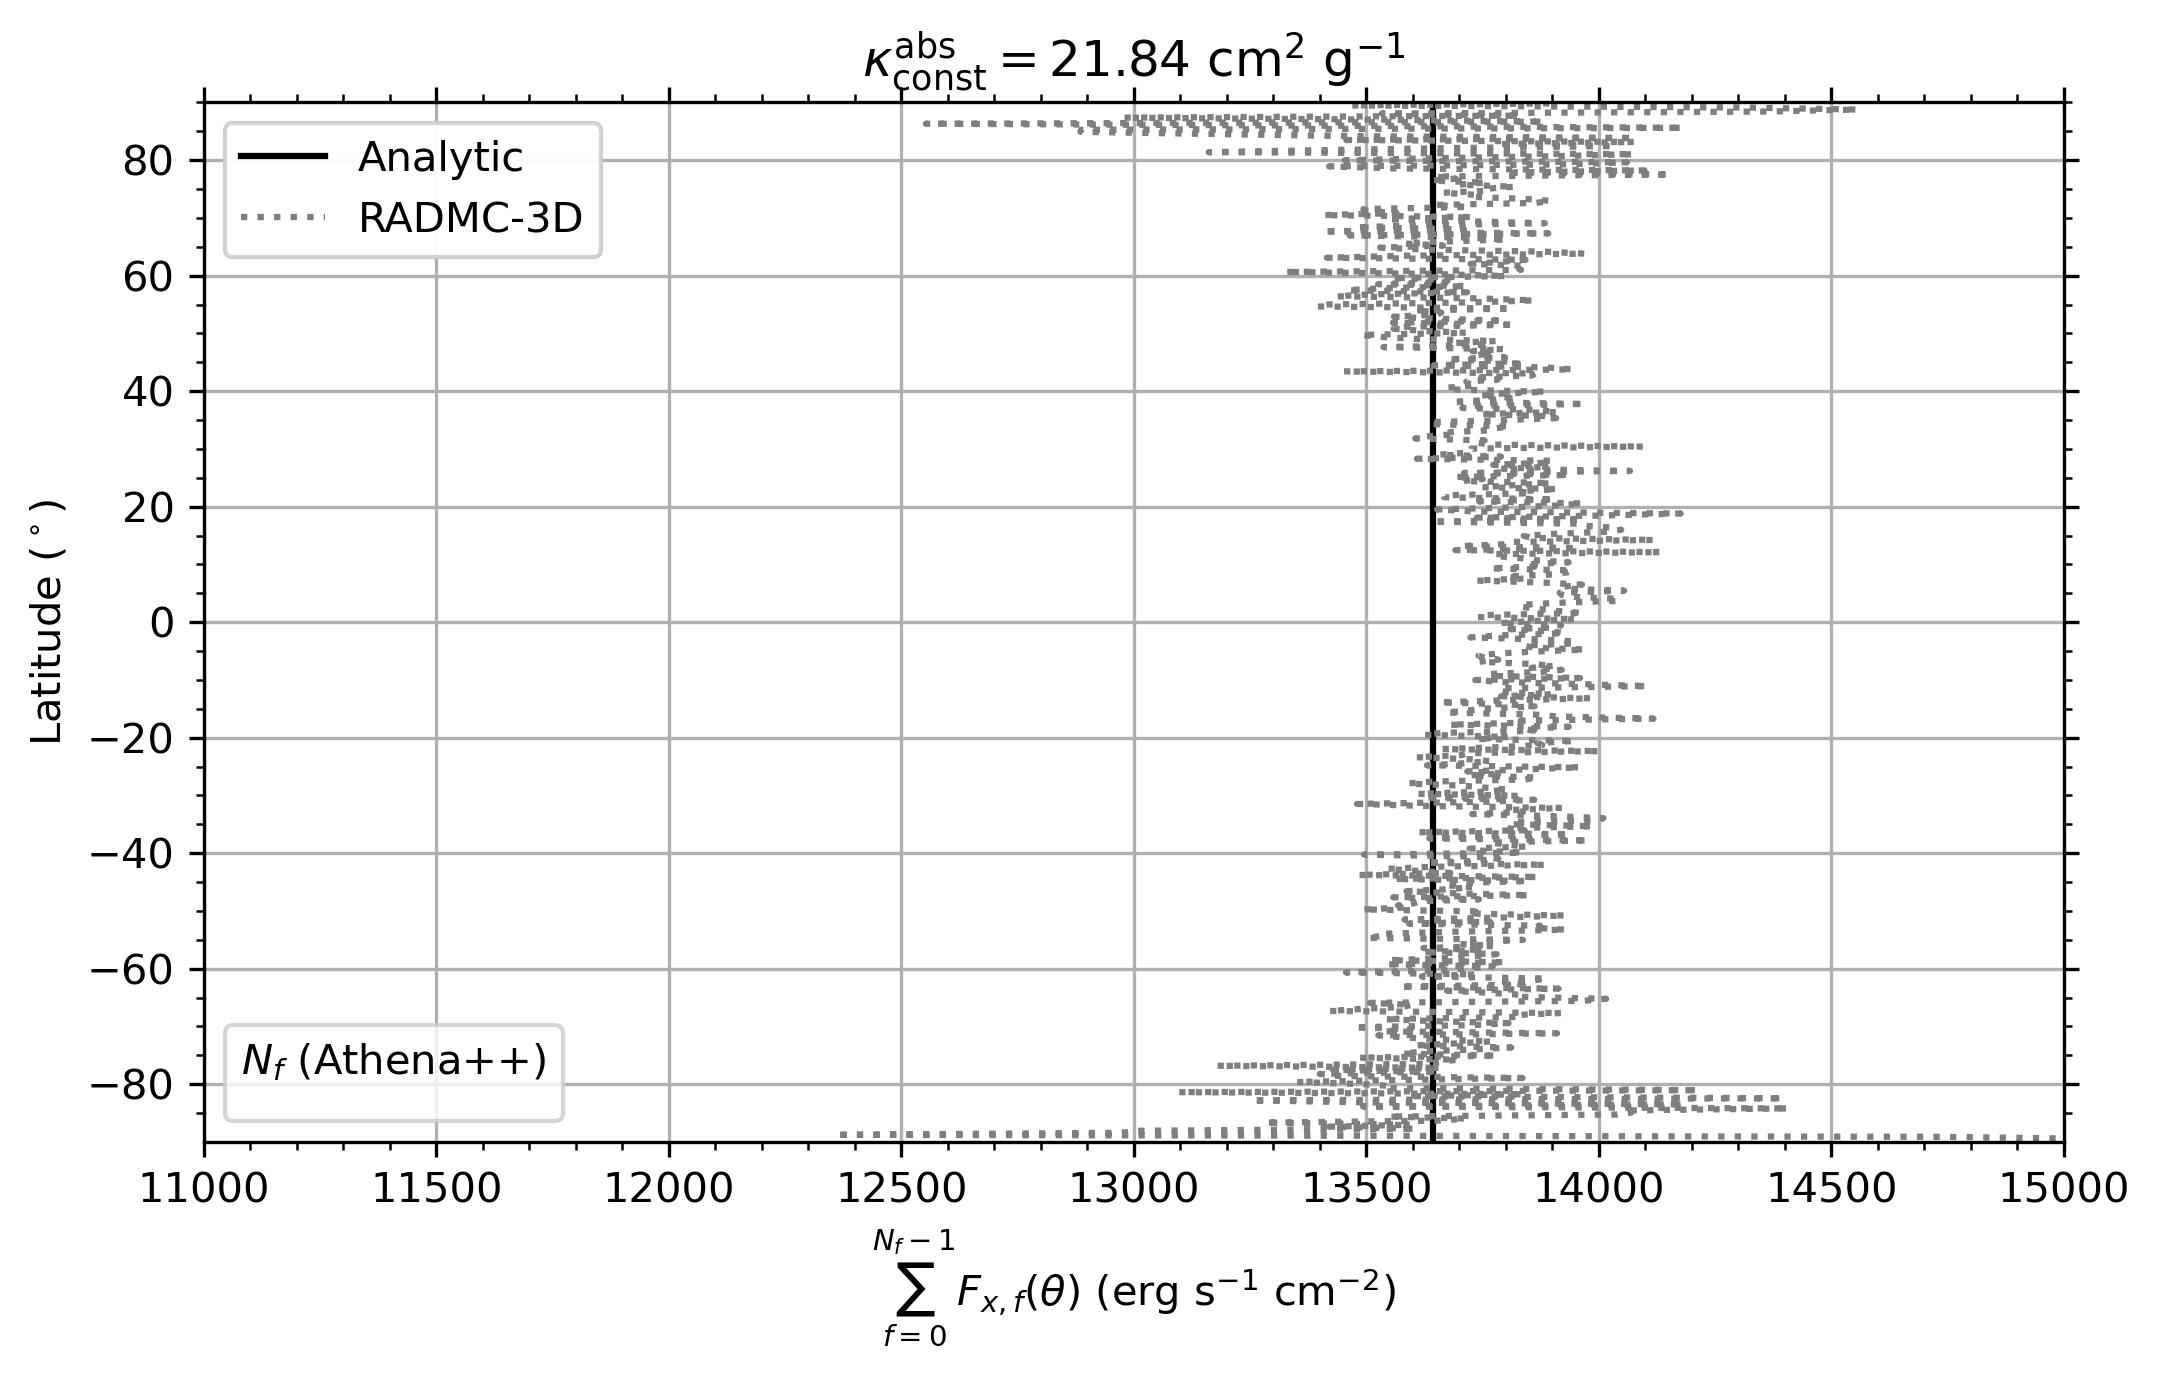

In [ ]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions, constants and units
rad2deg          = 180/np.pi           # [deg]
arad             = 7.565733250033928e-15
c_speed          = 2.99792458e10       # // speed of light
x1min            = 0.250163663377926   # minimum value of X1 [L_0]
T_unit           = 6.14e3              # T_0 [K]
R                = 1.16e-4             # solar radius [L_0]
T                = 9.42e-1             # solar temperature [T_0]

# Prepare plots
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue',
              'tab:purple', 'tab:pink','tab:cyan', 'tab:olive',
              'tab:brown', 'tab:gray']
lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
c_solns, ref_soln = [], []

# Analytic
F = np.power(T, 4)*np.power(R/x1min, 2)/4
ax.axvline(F*c_speed*arad*T_unit**4, c='black')
ref_soln.append(ax.plot([], [], c='black', label='Analytic')[0])

# RADMC-3D
data = analyze.readData(mint=True)
F = 4*np.pi*np.abs(np.trapz(data.meanint, data.freq, axis=-1))
ax.plot(F[0,:,0], 90-data.grid.y*rad2deg, c='tab:gray', ls='dotted')
ref_soln.append(ax.plot([], [], c='tab:gray', ls='dotted',
                label='RADMC-3D')[0])

# Athena++
# base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
# problem_id = 'const_opac_raytrace'
# runs = ['nfreq1', 'nfreq2', 'nfreq4', 'nfreq8']
# for i, run in enumerate(runs):
#   path = f'{base}/const_opac_raytrace/implicit/mf_flux/{run}'
#   athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
#   T_0 = athinput['radiation']['T_unit']
#   athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf',
#                             num_ghost=2)
#   # Radial flux field
#   Fx_field = np.zeros_like(athdf['rho'][0])
#   try:
#     N_f = athinput['radiation']['n_frequency']
#     for f in range(N_f):
#       Fx_field += athdf[f'Fr_{f}_1'][0]
#     Fx_field *= c_speed*arad*T_0**4
#   except KeyError:
#     Fx_field = athdf['Fr1'][0]*c_speed*arad*T_0**4
#   ax.plot(Fx_field[:, 0], 90-athdf['x2v']*rad2deg, color=tab_colors[i],
#           ls=lss[i])
#   c_solns.append(ax.plot([], [], c=tab_colors[i], ls=lss[i],
#                  label=run[5:])[0])

# Plot ghost points for colorless line style and add legends
color_legend = plt.legend(title=r'$N_f$ (Athena++)', handles=c_solns,
                          loc='lower left')
ref_legend = plt.legend(handles=ref_soln, loc='upper left')
ax.add_artist(color_legend)
ax.add_artist(ref_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(title=r'$\kappa_\mathrm{const}^\mathrm{abs}=21.84$ cm$^2$ g$^{-1}$',
       xlabel=r'$\sum_{f=0}^{N_f-1}F_{x,f}(\theta)$ (erg s$^{-1}$ cm$^{-2}$)',
       ylabel=r'Latitude ($^\circ$)', xlim=(11000, 15000), ylim=(-90, 90))
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('filename.pdf', bbox_inches='tight', pad_inches=0.01)

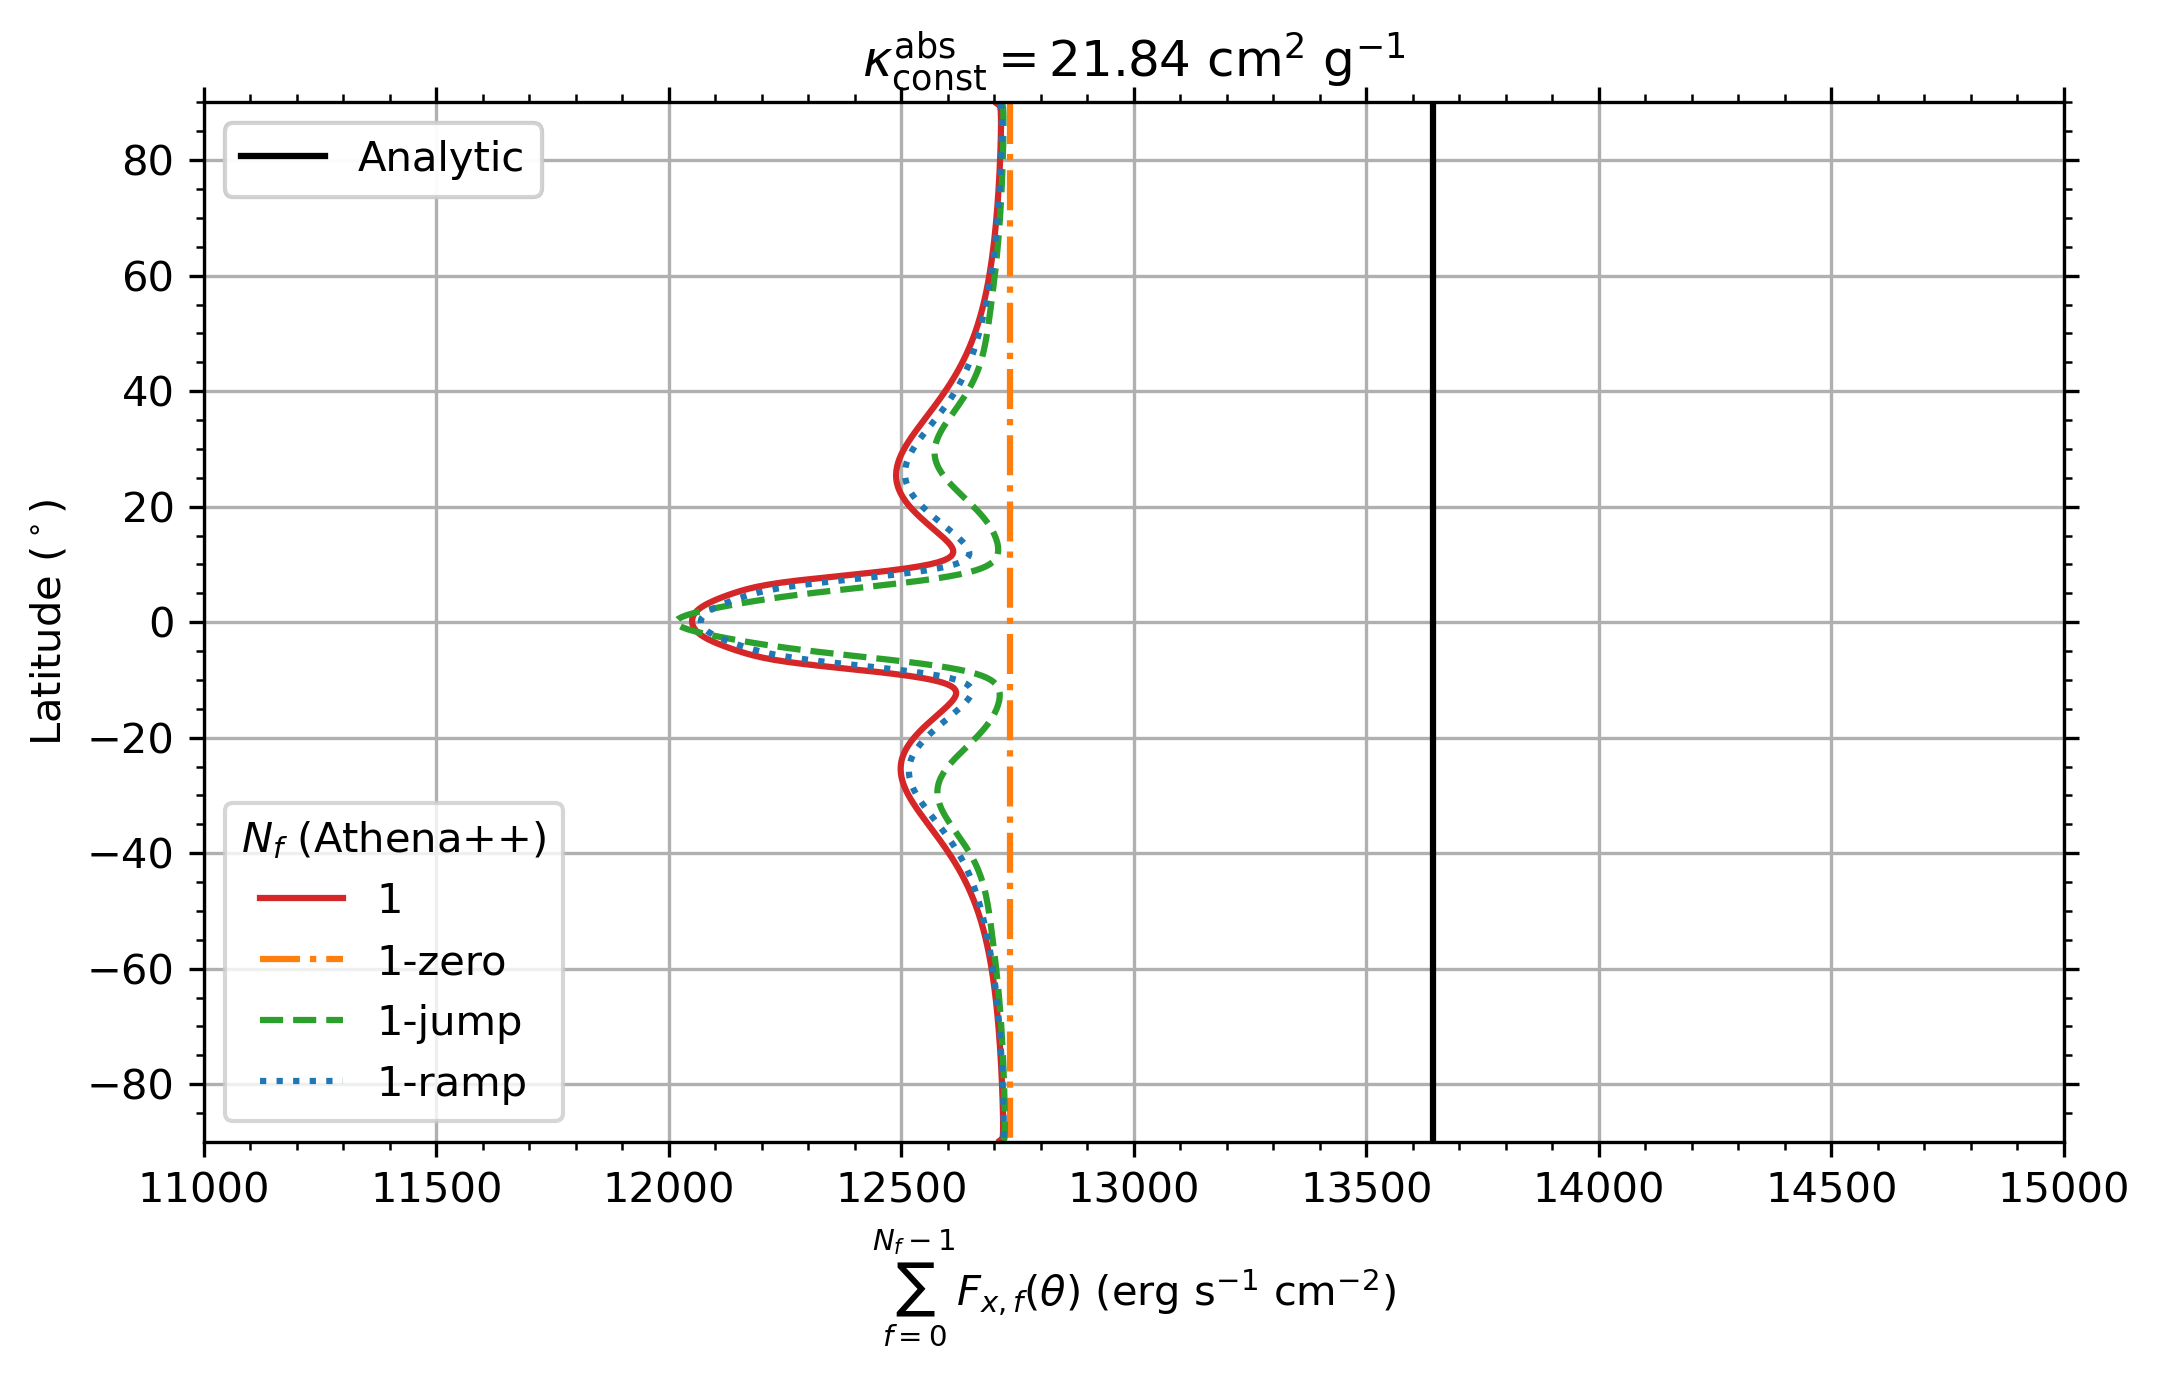

In [ ]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions, constants and units
rad2deg          = 180/np.pi           # [deg]
arad             = 7.565733250033928e-15
c_speed          = 2.99792458e10       # // speed of light
x1min            = 0.250163663377926   # minimum value of X1 [L_0]
T_unit           = 6.14e3              # T_0 [K]
R                = 1.16e-4             # solar radius [L_0]
T                = 9.42e-1             # solar temperature [T_0]

# Prepare plots
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue',
              'tab:purple', 'tab:pink','tab:cyan', 'tab:olive',
              'tab:brown', 'tab:gray']
lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
c_solns, ref_soln = [], []

# Analytic
F = np.power(T, 4)*np.power(R/x1min, 2)/4
ax.axvline(F*c_speed*arad*T_unit**4, c='black')
ref_soln.append(ax.plot([], [], c='black', label='Analytic')[0])

# RADMC-3D
# data = analyze.readData(mint=True)
# F = 4*np.pi*np.abs(np.trapz(data.meanint, data.freq, axis=-1))
# ax.plot(F[0,:,0], 90-data.grid.y*rad2deg, c='tab:gray', ls='dotted')
# ref_soln.append(ax.plot([], [], c='tab:gray', ls='dotted',
#                 label='RADMC-3D')[0])

# Athena++
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'const_opac_raytrace'
runs = ['nfreq1', 'nfreq1-zero', 'nfreq1-jump', 'nfreq1-ramp']
for i, run in enumerate(runs):
  path = f'{base}/const_opac_raytrace/implicit/mf_flux/{run}'
  athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
  T_0 = athinput['radiation']['T_unit']
  athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
  # Radial flux field
  Fx_field = np.zeros_like(athdf['rho'][0])
  try:
    N_f = athinput['radiation']['n_frequency']
    for f in range(N_f):
      Fx_field += athdf[f'Fr_{f}_1'][0]
    Fx_field *= c_speed*arad*T_0**4
  except KeyError:
    Fx_field = athdf['Fr1'][0]*c_speed*arad*T_0**4
  ax.plot(Fx_field[:, 0], 90-athdf['x2v']*rad2deg, color=tab_colors[i],
          ls=lss[i])
  c_solns.append(ax.plot([], [], c=tab_colors[i], ls=lss[i],
                 label=run[5:])[0])

# Plot ghost points for colorless line style and add legends
color_legend = plt.legend(title=r'$N_f$ (Athena++)', handles=c_solns,
                          loc='lower left')
ref_legend = plt.legend(handles=ref_soln, loc='upper left')
ax.add_artist(color_legend)
ax.add_artist(ref_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(title=r'$\kappa_\mathrm{const}^\mathrm{abs}=21.84$ cm$^2$ g$^{-1}$',
       xlabel=r'$\sum_{f=0}^{N_f-1}F_{x,f}(\theta)$ (erg s$^{-1}$ cm$^{-2}$)',
       ylabel=r'Latitude ($^\circ$)', xlim=(11000, 15000), ylim=(-90, 90))
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('filename.pdf', bbox_inches='tight', pad_inches=0.01)

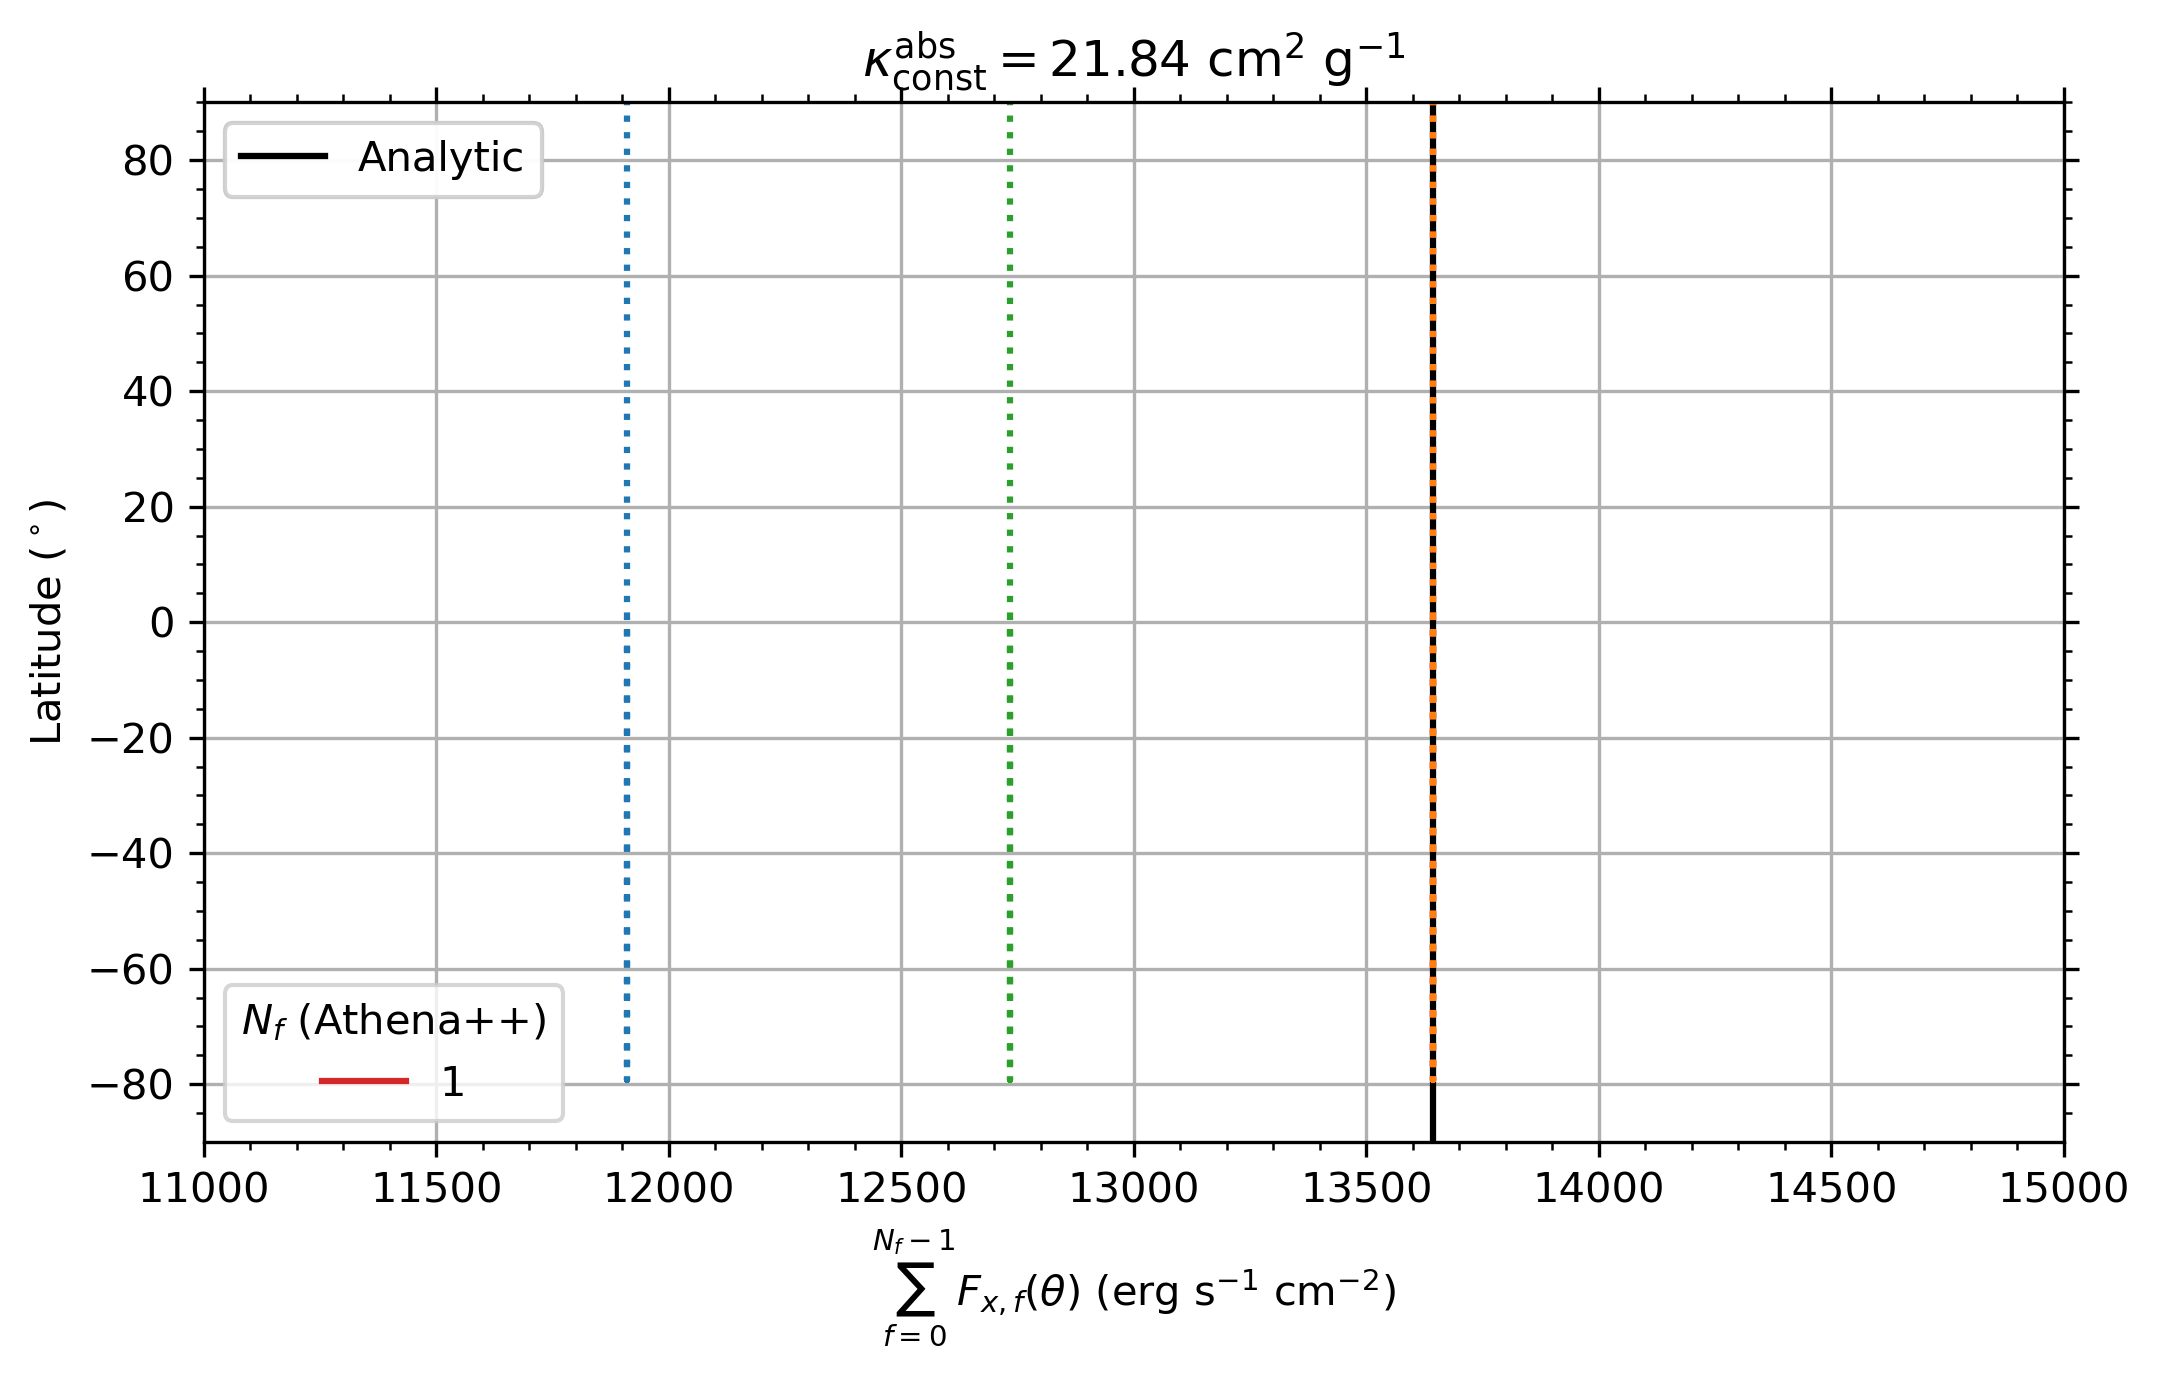

In [ ]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions, constants and units
rad2deg          = 180/np.pi           # [deg]
arad             = 7.565733250033928e-15
c_speed          = 2.99792458e10       # // speed of light
x1min            = 0.250163663377926   # minimum value of X1 [L_0]
T_unit           = 6.14e3              # T_0 [K]
R                = 1.16e-4             # solar radius [L_0]
T                = 9.42e-1             # solar temperature [T_0]

# Prepare plots
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue',
              'tab:purple', 'tab:pink','tab:cyan', 'tab:olive',
              'tab:brown', 'tab:gray']
lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
c_solns, ref_soln = [], []

# Analytic
F = np.power(T, 4)*np.power(R/x1min, 2)/4
ax.axvline(F*c_speed*arad*T_unit**4, c='black')
ref_soln.append(ax.plot([], [], c='black', label='Analytic')[0])

# RADMC-3D
# data = analyze.readData(mint=True)
# F = 4*np.pi*np.abs(np.trapz(data.meanint, data.freq, axis=-1))
# ax.plot(F[0,:,0], 90-data.grid.y*rad2deg, c='tab:gray', ls='dotted')
# ref_soln.append(ax.plot([], [], c='tab:gray', ls='dotted',
#                 label='RADMC-3D')[0])

# Athena++
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'const_opac_raytrace'
runs = ['nfreq1']#, 'nfreq1-zero', 'nfreq1-jump', 'nfreq1-ramp']
for i, run in enumerate(runs):
  path = f'{base}/const_opac_raytrace/implicit/mf_flux/{run}'
  athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
  T_0 = athinput['radiation']['T_unit']
  athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf',
                            num_ghost=1)
  # Radial flux field
  Fx_field = np.zeros_like(athdf['rho'][0])
  try:
    N_f = athinput['radiation']['n_frequency']
    for f in range(N_f):
      Fx_field += athdf[f'Fr_{f}_1'][0]
    Fx_field *= c_speed*arad*T_0**4
  except KeyError:
    Fx_field = athdf['Fr1'][0]*c_speed*arad*T_0**4
  ax.plot(Fx_field[:, 0], 90-athdf['x2v']*rad2deg, color=tab_colors[i],
          ls='dotted')
  ax.plot(Fx_field[:, 1], 90-athdf['x2v']*rad2deg, color=tab_colors[i+1],
          ls='dotted')
  ax.plot(Fx_field[:, 2], 90-athdf['x2v']*rad2deg, color=tab_colors[i+2],
          ls='dotted')
  ax.plot(Fx_field[:, 3], 90-athdf['x2v']*rad2deg, color=tab_colors[i+3],
          ls='dotted')
  c_solns.append(ax.plot([], [], c=tab_colors[i], ls=lss[i],
                 label=run[5:])[0])

# Plot ghost points for colorless line style and add legends
color_legend = plt.legend(title=r'$N_f$ (Athena++)', handles=c_solns,
                          loc='lower left')
ref_legend = plt.legend(handles=ref_soln, loc='upper left')
ax.add_artist(color_legend)
ax.add_artist(ref_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(title=r'$\kappa_\mathrm{const}^\mathrm{abs}=21.84$ cm$^2$ g$^{-1}$',
       xlabel=r'$\sum_{f=0}^{N_f-1}F_{x,f}(\theta)$ (erg s$^{-1}$ cm$^{-2}$)',
       ylabel=r'Latitude ($^\circ$)', xlim=(11000, 15000), ylim=(-90, 90))
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('filename.pdf', bbox_inches='tight', pad_inches=0.01)